# Surface Mass Balance: XGB 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
#%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "update"



In [1]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Visualizations
import matplotlib.pyplot as plt
from matplotlib import pyplot

# TS
from statsmodels.tsa.seasonal import seasonal_decompose

# Set WD
import os
from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

'/Users/nilsfulde/Desktop/Master_Thesis/scripts'

## Load Stations

In [94]:
# This bit to define the data that is to be loaded
import glob

# Define the directory path where the CSV files are located
#input_path = r'../data/promice/preprocessed/South_West/'
input_path = r'../data/promice/preprocessed/North_East/'

# Define a pattern to match the filenames of the CSV files
pattern = '*.csv'
#staion_list = ['SCO_L.csv','KAN_L.csv']

# Use glob to get a list of all files that match the pattern
filenames = glob.glob(input_path + pattern)

dfs = []
for file in filenames:
    df = pd.read_csv(file, index_col=False)
    dfs.append(df)
df = pd.concat(dfs)

df = df.reset_index(drop=True)

df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")

In [95]:
df = df[df['stid'] != 'NUK_U']
df = df[df['stid'] != 'QAS_U']
df = df[df['stid'] != 'SCO_U']
df = df[df['stid'] != 'KPC_L']

In [2]:
# Load Unique Stations
station_list = pd.read_csv(r'../data/promice/stations.csv')

# This bit to define the data that is to be loaded
import glob

# Define the directory path where the CSV files are located
input_path = r'../data/promice/preprocessed/daily/'

# Define a pattern to match the filenames of the CSV files
pattern = '*.csv'

# Use glob to get a list of all files that match the pattern
filenames = glob.glob(input_path + pattern)

dfs = []
for file in filenames:
    df = pd.read_csv(file, index_col=False)
    dfs.append(df)
df = pd.concat(dfs)

In [3]:
#df = df[df['stid'] == 'SCO_L']

In [4]:
stationss = ['KPC_L',
'SCO_L',
'SCO_U',
'THU_L',
'UPE_L',
'UPE_U',
'MIT',
'TAS_L',
'KAN_L',
'NUK_L',
'NUK_U',
'QAS_L',
'QAS_U',]

df = df[df['stid'].isin(stationss)]

## melt onset day / melt end day detection

In [5]:
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")
df['Year'] = df['Datetime'].dt.year
df['DayOfYear'] = df['Datetime'].dt.dayofyear

# Initialize new columns with default values
df['first_melt_day'] = False
df['last_melt_day'] = False

for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    unique_years = df_station['Year'].unique()
    for year in unique_years:
        # Filter data for the current year
        year_data = df_station[df_station['Year'] == year]

        # Find the first and last melt day
        first_melt_day = year_data.loc[year_data['Ablation'] == True]['DayOfYear'].min()
        last_melt_day = year_data.loc[year_data['Ablation'] == True]['DayOfYear'].max()

        # Update the original DataFrame
        df.loc[(df['stid'] == i) & (df['Year'] == year) & (df['DayOfYear'] == first_melt_day), 'first_melt_day'] = True
        df.loc[(df['stid'] == i) & (df['Year'] == year) & (df['DayOfYear'] == last_melt_day), 'last_melt_day'] = True

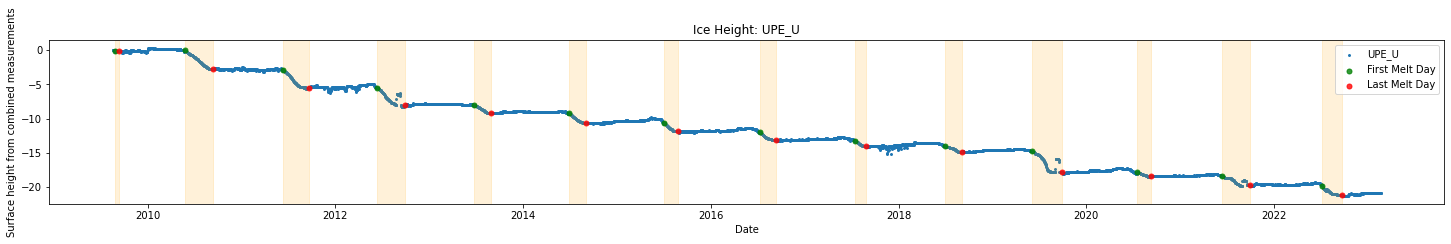

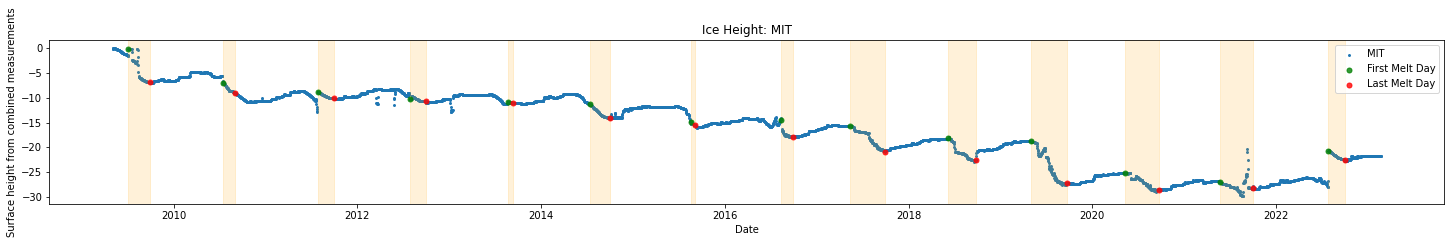

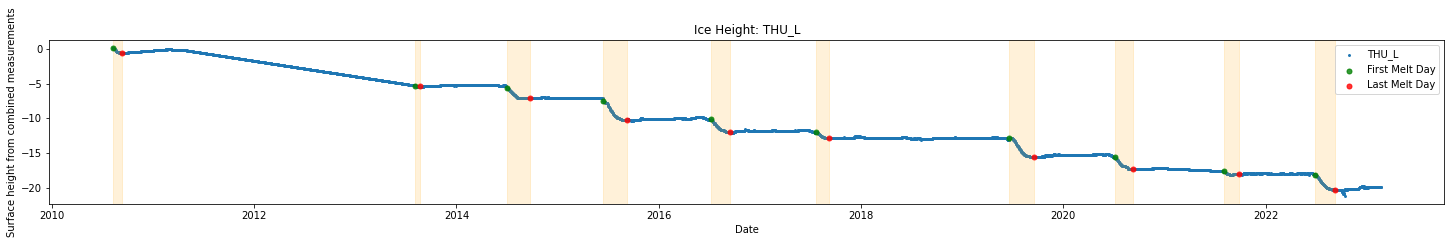

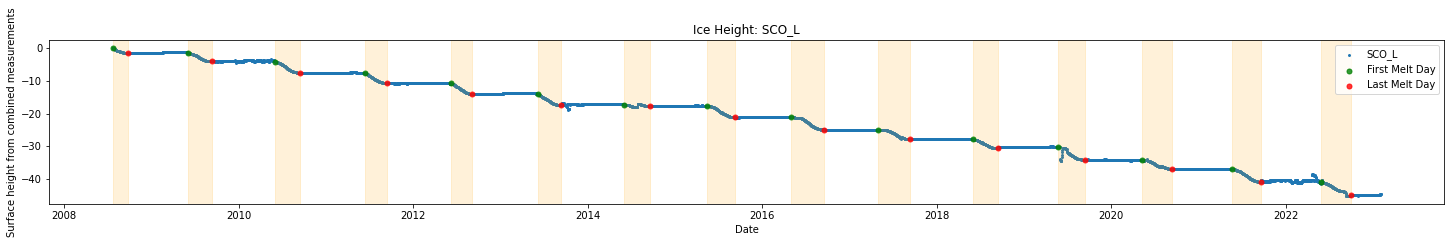

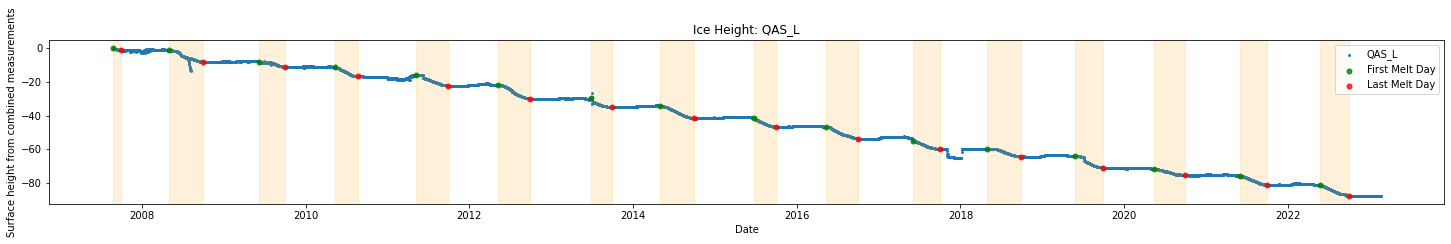

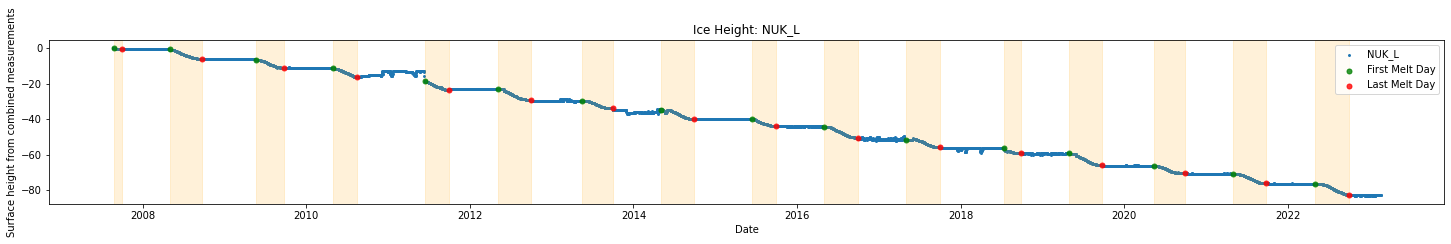

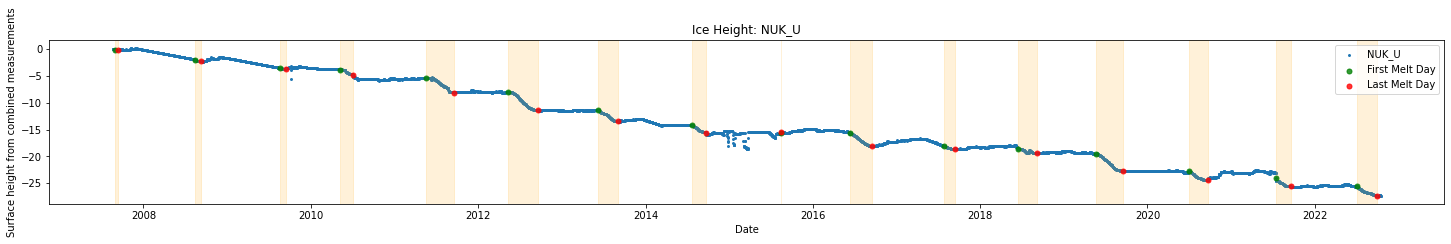

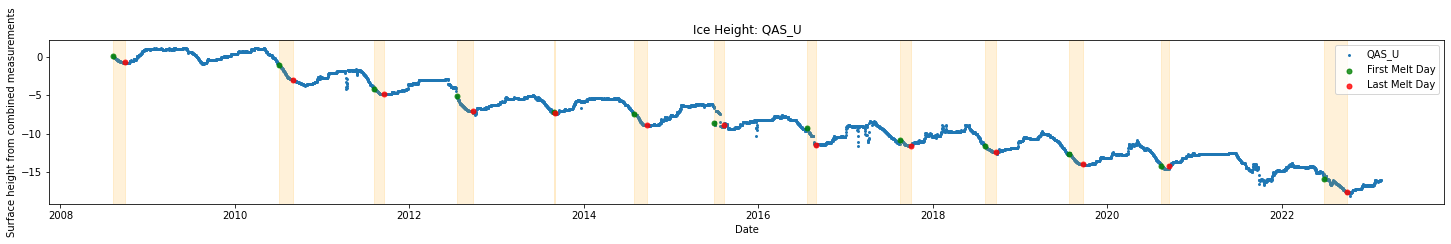

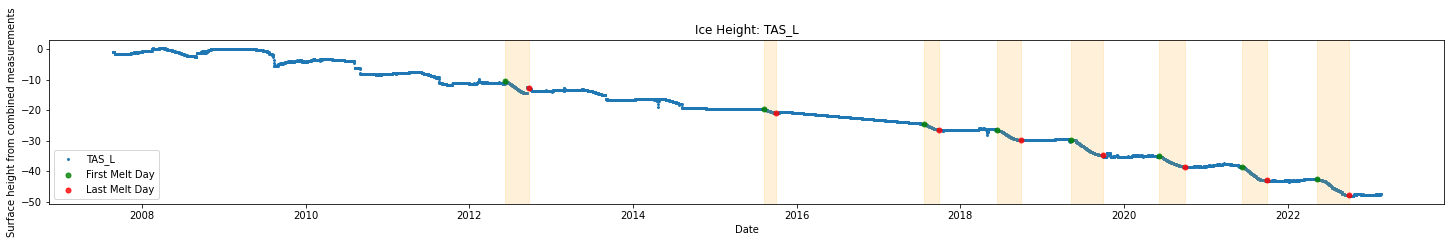

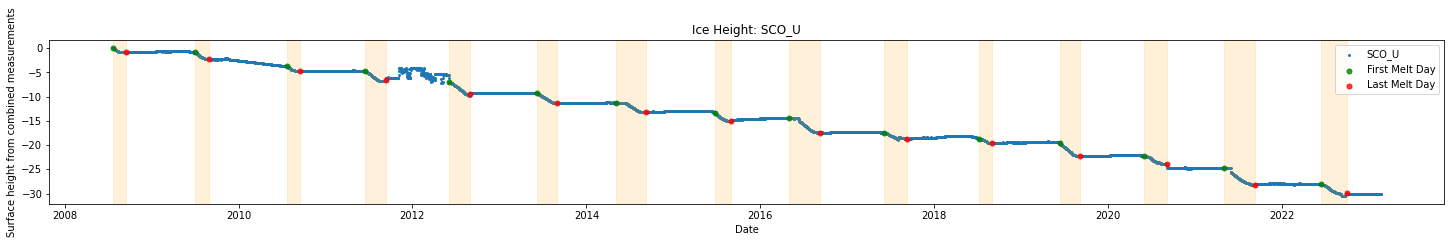

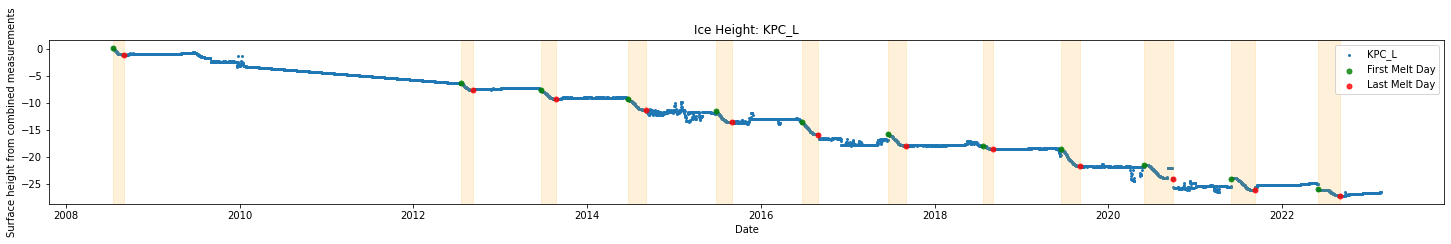

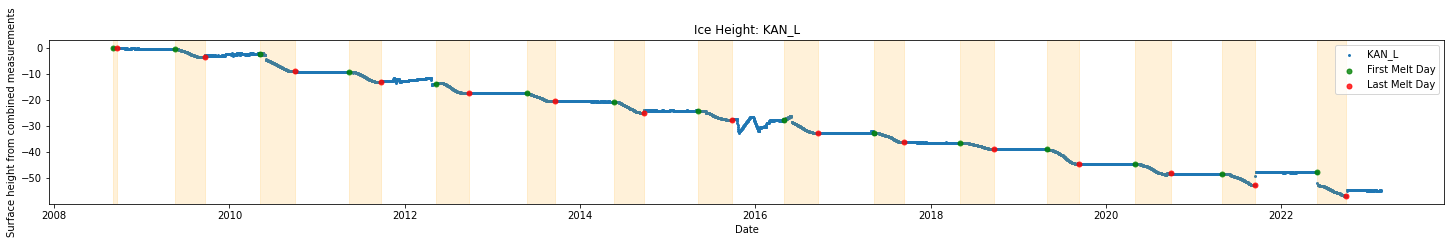

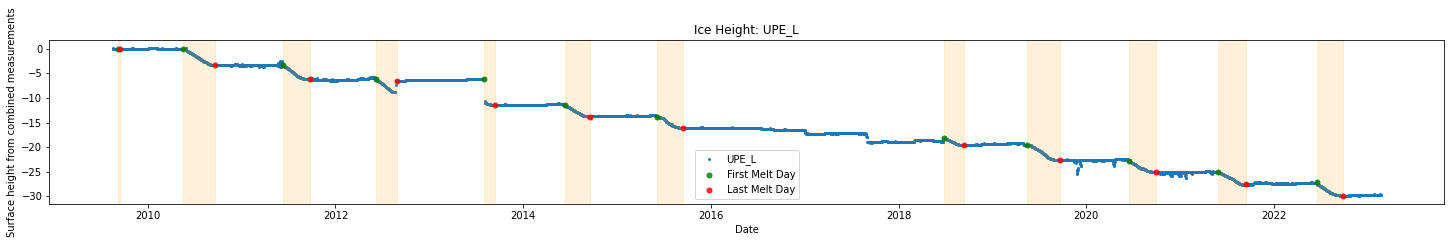

In [6]:
import matplotlib.pyplot as plt
import pandas as pd


for stid in df['stid'].unique():
    station_df = df[df['stid'] == stid]
    
    # filter the dataframe to only include rows where ablation occurred
    ablation_df = station_df[station_df['Ablation'] == True]

    # create a line plot for each station, highlighting the periods of ablation
    fig, ax = plt.subplots(figsize=(25,3))
    
    # Plot the blue scatter points
    plt.scatter(station_df['Datetime'], station_df['Surface height from combined measurements'], c='C0',  marker='.', label=stid, s=15)
    
    first_melt_days = station_df[station_df['first_melt_day'] == True]['Datetime']
    last_melt_days = station_df[station_df['last_melt_day'] == True]['Datetime']
    
    for first_day, last_day in zip(first_melt_days, last_melt_days):
        ax.axvspan(first_day, last_day, alpha=0.15, color='orange')
    
    # Plot the first melt day values
    plt.scatter(first_melt_days, station_df.loc[first_melt_days.index, 'Surface height from combined measurements'], c='g', alpha=0.8, marker='.', label='First Melt Day', s=100)
    
    # Plot the last melt day values
    plt.scatter(last_melt_days, station_df.loc[last_melt_days.index, 'Surface height from combined measurements'], c='r', alpha=0.8 , marker='.', label='Last Melt Day', s=100)

    # set plot title, axis labels and legend
    ax.set_title(f'Ice Height: {stid}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Surface height from combined measurements')
    ax.legend()
    
    # Save the plot in the Downloads folder
   # plot_filename = f'Surface_Height_{stid}.png'
   # plt.savefig(os.path.join(os.path.expanduser("~"), "Downloads", plot_filename), dpi=300)
    
plt.show()
    

## Time Series Decomposition

In [7]:
# https://datastud.dev/posts/python-seasonality-how-to

In [8]:
# This bit to decompose for each station
df = df[df['stid'] != 'QAS_Lv3']
df = df[df['stid'] != 'Roof_PROMICE']
df = df[df['stid'] != 'LYN_L']
df = df[df['stid'] != 'LYN_T']
df = df[df['stid'] != 'KPC_Lv3']
df = df[df['stid'] != 'KPC_Uv3']
df = df[df['stid'] != 'JAR_O']
df = df[df['stid'] != 'SWC_O']
df = df[df['stid'] != 'THU_L2']
df = df[df['stid'] != 'Roof_GEUS']
df = df[df['stid'] != 'ZAK_Uv3']
df = df[df['stid'] != 'WEG_B']


df = df[df['Surface height from combined measurements'].notna()] 

for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    if len(df_station) > 730: 
        exec(f"result_{i} = seasonal_decompose(df_station['Surface height from combined measurements'], model='additive', period=365)")
    else:
        print("Station to remove:", i)
        

In [9]:
# This bit to add decomposition to df and smooth the residual component
ts = pd.DataFrame()

for i in df["stid"].unique().tolist():
    
    # Get data frame for the current station
    df_station = df[df['stid'] == i]

    df_station['observed'] = eval(f"result_{i}.observed")
    df_station['residual'] = eval(f"result_{i}.resid") 
    df_station['seasonal'] = eval(f"result_{i}.seasonal") 
    df_station['trend'] = eval(f"result_{i}.trend")
    df_station['residual_smoothed'] = eval(f"result_{i}.resid") 
    
    # Set the window size and threshold
    window_size = 7
    
    #Outliers based on incremental sum
    threshold_incremental_sum = df_station['residual'].diff().rolling(window_size).sum().quantile(0.8)
    threshold_slope = df_station['residual_smoothed'].diff().abs().quantile(0.8)
        # Calculate the sum of incremental changes over the rolling window
    incremental_sum = df_station['residual'].diff().rolling(window_size).sum()
        # Replace the residuals that exceed the threshold with NaN
    df_station['residual_smoothed'] = df_station['residual']
    df_station.loc[incremental_sum > threshold_incremental_sum, 'residual_smoothed'] = np.nan

    # Outliers based on slope
    slope = df_station['residual_smoothed'].diff().abs()
        # Calculate the 80th percentile of the slopes
    threshold_slope = slope.quantile(0.8)
        # Remove values where the slope is steeper than the threshold
    df_station.loc[slope > threshold_slope, 'residual_smoothed'] = np.nan

    # fill in the NaN values with linear interpolation
    #df_station['residual_smoothed'].interpolate(method='linear', inplace=True)

    # Add new column for seasonal residual
    df_station['seasonal_residual'] = df_station['residual'].fillna(0) + df_station['seasonal']
    
    # Add column for current station
    df_station['stid'] = i
    
    # Append to time series data frame
    ts = ts.append(df_station[['Datetime', 'stid', 'observed', 'residual', 'seasonal', 'trend', 'residual_smoothed', 'seasonal_residual']])

# Merge time series data frame with original data frame
df = pd.merge(df, ts, on=['Datetime', 'stid'], how='left')


In [10]:
# This bit to generate the periods that we want to focus on
df['seasonal'] = df['seasonal'].astype(float)
# create a new column to store the periods
df['Periods'] = ''

for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    # iterate over each year in the dataframe
    for year in df_station['Datetime'].dt.year.unique():
        year_data = df_station[df_station['Datetime'].dt.year == year]
        if len(year_data.index) > 300:
            max_index = year_data['seasonal'].idxmax()
            min_index = year_data['seasonal'].idxmin()

            # set the periods in the new column for the maximum value
            df.loc[max_index-5:max_index, 'Periods'] = 'pre_max'
            df.loc[max_index:max_index+6, 'Periods'] = 'post_max'

            # set the periods in the new column for the minimum value
            df.loc[min_index-5:min_index, 'Periods'] = 'pre_min'
            df.loc[min_index:min_index+6, 'Periods'] = 'post_min'
        else:
            continue 

In [11]:
def mround(x, m=5):
    '''Helper method for multiple round'''
    return int(m * round(float(x)/m))

def plot_components(df, station):
    """Plot data for initial visualization
    Args:
        df (pandas dataframe)
    """
    df = df[df['stid'] == station]
    
    df_axis = df.fillna(0)
    ymin = mround(np.min([df_axis.observed, df_axis.trend, df_axis.seasonal, df_axis.residual ]),5)
    ymax = mround(np.max([df_axis.observed, df_axis.trend, df_axis.seasonal, df_axis.residual]),5)
    ymin -= 5
    ymax += 5

    plt.figure(figsize=(20,20))

    #plt.subplot(4,1,1)
    #plt.title("Original Data")
    #plt.ylim(ymin, ymax)
    #plt.plot(df.index, df.observed)

    plt.subplot(4,1,1)
    plt.title("Trend")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.trend)

    plt.subplot(4,1,2)
    plt.title("Seasonal")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.seasonal)

    plt.subplot(4,1,3)
    plt.title("Residual")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.residual)
    
    plt.subplot(4,1,4)
    plt.title("residual_smoothed")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.residual_smoothed)

    
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    

In [12]:
df["stid"].unique().tolist()

['UPE_U',
 'MIT',
 'THU_L',
 'SCO_L',
 'QAS_L',
 'NUK_L',
 'NUK_U',
 'QAS_U',
 'TAS_L',
 'SCO_U',
 'KPC_L',
 'KAN_L',
 'UPE_L']

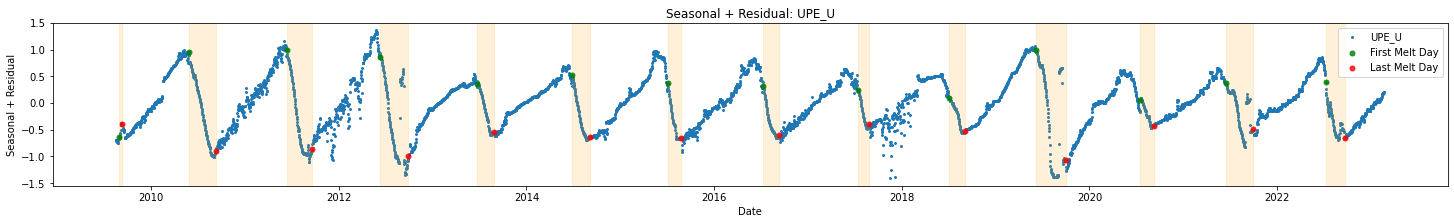

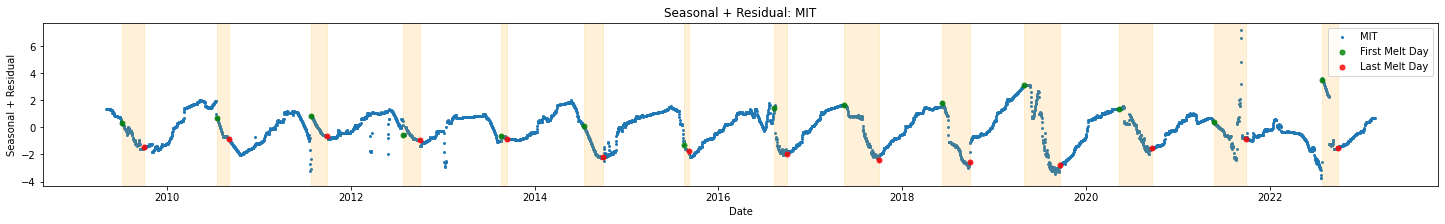

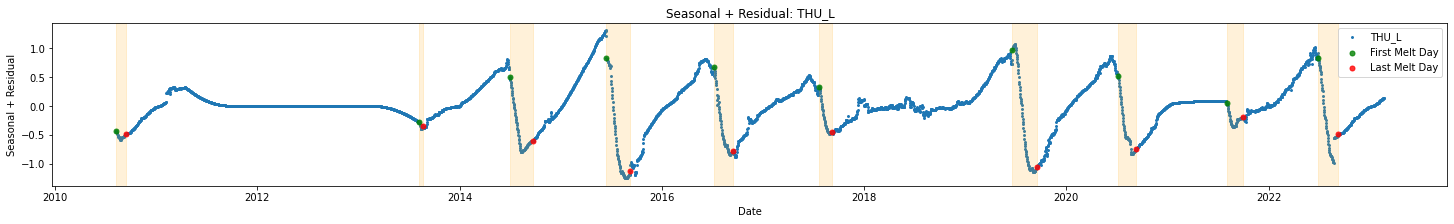

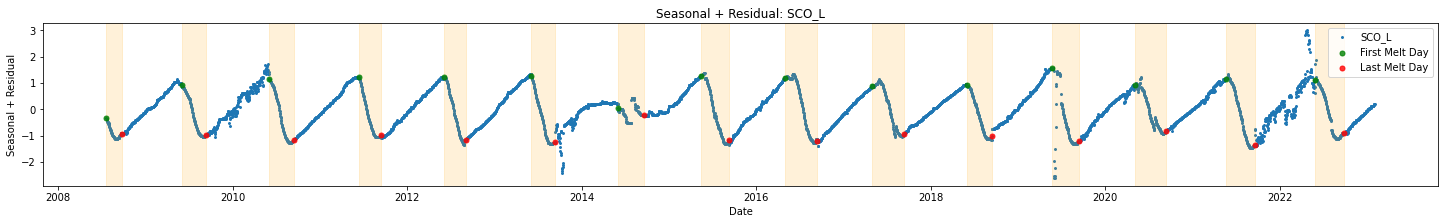

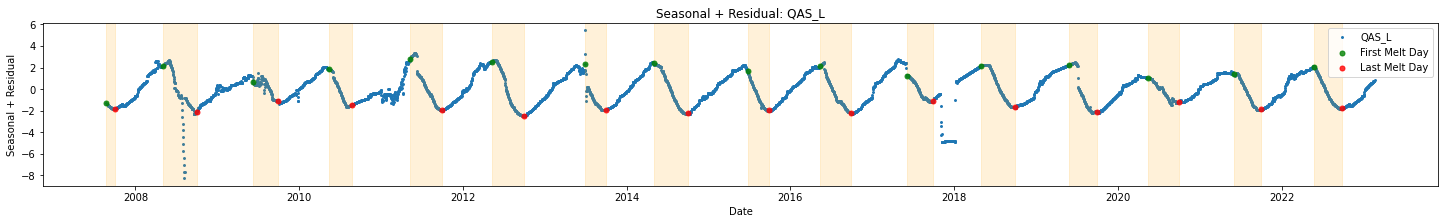

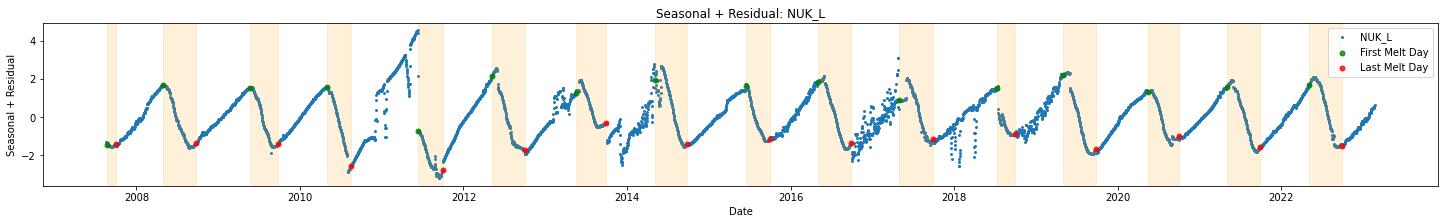

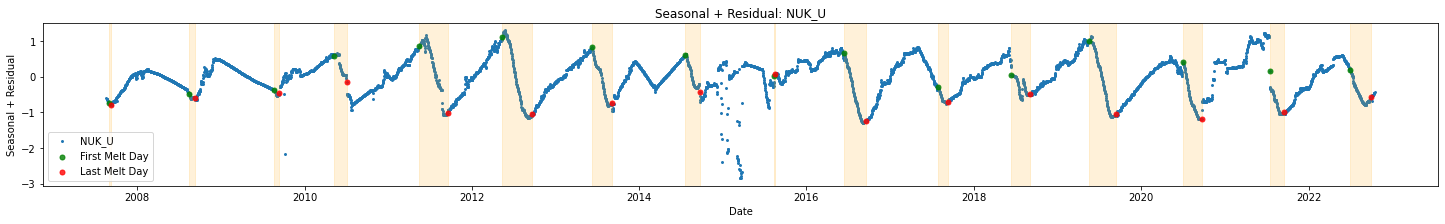

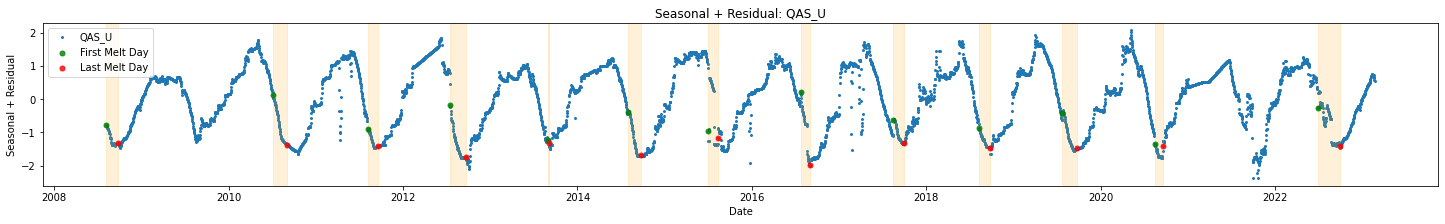

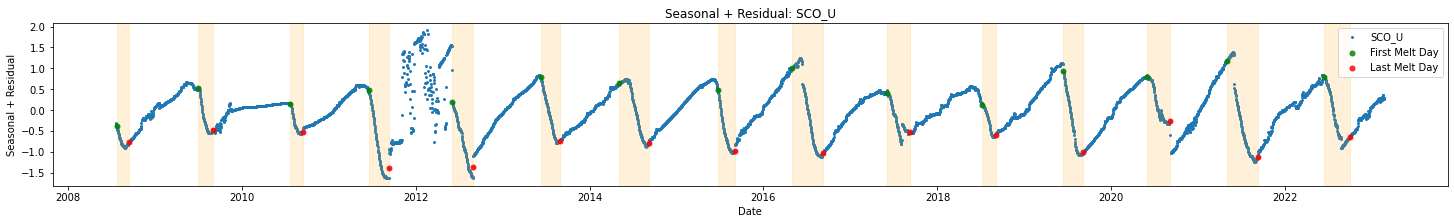

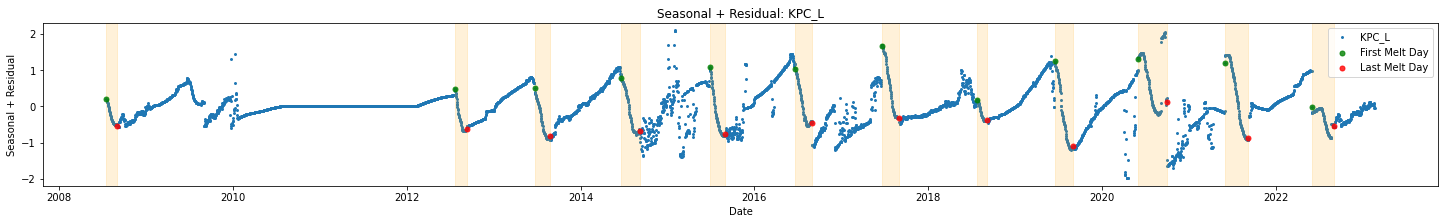

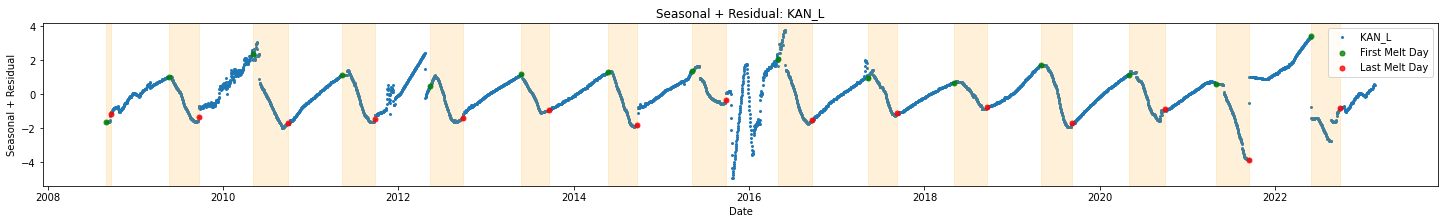

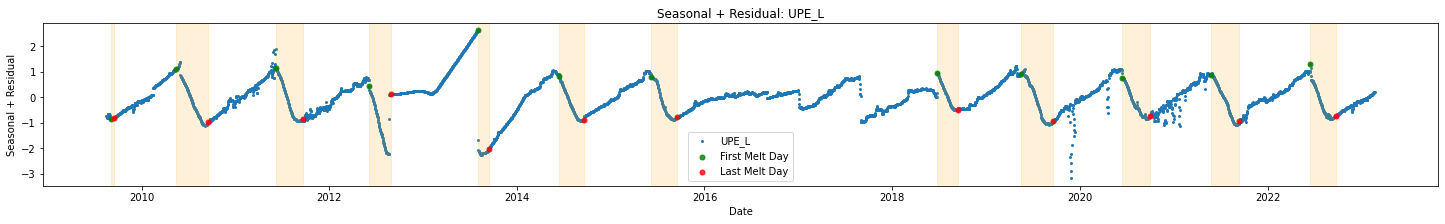

In [13]:
import matplotlib.pyplot as plt
import pandas as pd


for stid in df['stid'].unique():
    station_df = df[df['stid'] == stid]
    # filter the dataframe to only include rows where ablation occurred
    ablation_df = df[df['Ablation'] == True]

    # create a line plot for each station, highlighting the periods of ablation
    fig, ax = plt.subplots(figsize=(25,3))

    
    # Plot the blue scatter points
    plt.scatter(station_df['Datetime'], station_df['seasonal_residual'], c='C0',  marker='.', label=stid, s=15)
    
    first_melt_days = station_df[station_df['first_melt_day'] == True]['Datetime']
    last_melt_days = station_df[station_df['last_melt_day'] == True]['Datetime']
    
    for first_day, last_day in zip(first_melt_days, last_melt_days):
        ax.axvspan(first_day, last_day, alpha=0.15, color='orange')
    
    # Plot the first melt day values
    plt.scatter(first_melt_days, station_df.loc[first_melt_days.index, 'seasonal_residual'], c='g', alpha=0.8, marker='.', label='First Melt Day', s=100)
    
    # Plot the last melt day values
    plt.scatter(last_melt_days, station_df.loc[last_melt_days.index, 'seasonal_residual'], c='r', alpha=0.8 , marker='.', label='Last Melt Day', s=100)

    # set plot title, axis labels and legend
    ax.set_title(f'Seasonal + Residual: {stid}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Seasonal + Residual')
    ax.legend()
    
    # Save the plot in the Downloads folder
   # plot_filename = f'seasonal_residual_{stid}.png'
   # plt.savefig(os.path.join(os.path.expanduser("~"), "Downloads", plot_filename), dpi=300)
    
    
plt.show()


In [14]:
def plt_seasonal_residual(df,station):
    df = df[df['stid'] == station]
    
    df_axis = df.fillna(0)
    ymin = np.round(np.min([df_axis.seasonal_residual]), 5) - 5
    ymax = np.round(np.max([df_axis.seasonal_residual]), 5) + 5

    plt.figure(figsize=(20,15))

    # Plot the seasonal_residual values
    plt.subplot(4,1,4)
    plt.title("seasonal_residual")
    plt.ylim(ymin, ymax)

    # Plot the pre_max values
   # pre_max_indices = df[df['Periods'] == 'pre_max'].index
   # plt.scatter(pre_max_indices, df.loc[pre_max_indices, 'seasonal_residual'], c='r', marker='.', label='pre_max', s=20 )

    # Plot the post_max values
    #post_max_indices = df[df['Periods'] == 'post_max'].index
    #plt.scatter(post_max_indices, df.loc[post_max_indices, 'seasonal_residual'], c='g', marker='.', label='post_max',s=8)

    # Plot the pre_min values
    #pre_min_indices = df[df['Periods'] == 'pre_min'].index
    #plt.scatter(pre_min_indices, df.loc[pre_min_indices, 'seasonal_residual'], c='r', marker='.', label='pre_min',s=8)

    # Plot the post_min values
    #post_min_indices = df[df['Periods'] == 'post_min'].index
    #plt.scatter(post_min_indices, df.loc[post_min_indices, 'seasonal_residual'], c='g', marker='.', label='post_min',s=8)

    plt.plot(df.index, df.seasonal_residual)#, c = "grey")

#plt_seasonal_residual(df,"SCO_L")


In [15]:
#plot_components(df, 'SCO_L')

## Regression Analysis

##### Set target variable

In [16]:
y = 'seasonal_residual'

##### Pre-processing (0.1: Change months to cycle)

In [17]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")

#Create new columns
df['year'] = df['Datetime'].dt.year 
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day

#Drop the datetime column
#df.drop(columns=['Datetime'], inplace=True)

In [18]:
# This bit to change the datetime variables into a form that a ML models can understand (continued)
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html 

# Use CyclicalFeatures Package to convert year, month, day & hour
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(variables=None, drop_original=True)

# Remove only values from Wind direction because CyclicalFeatures does not work with NA values
df_wind = df[df['Wind from direction (upper boom)'].notna()] 
cyclical_df = cyclical.fit_transform(df_wind[['Wind from direction (upper boom)']]) 
df = pd.merge(df, cyclical_df, left_index=True, right_index=True)

# Exclude not needed columns in exclude list
cyclical_df_time = cyclical.fit_transform(df[['month',  'day']]) 

df = pd.merge(df, cyclical_df_time, left_index=True, right_index=True)

##### Pre-processing (1.0: Filter relevant periods)

In [19]:
#df =  df[df['Melting Season'].isin(['pre', 'beginning', 'middle', 'end'])]

#df =  df[df['Ablation'].isin([True])]

In [20]:
df = df[df[y].notna()] 

In [21]:
#df = df.reset_index(drop=True)

In [22]:
# This bit retrieve the indexes for all melting season categories and remove column from df
# Fill NA values in Melting season as blank
df['Melting Season'] = df['Melting Season'].fillna('no_ablation')

for category in ['pre', 'beginning', 'middle', 'end', 'no_ablation']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

# This bit retrieve the indexes for Ablation periods
for category in [True]:
    exec(f"indices_ablation = df[df['Ablation'] == {category}].index")

indices_all = df[df['Ablation'].isin([True, False])].index

for category in ['pre_max', 'post_max', 'pre_min', 'post_min']:
    exec(f"indices_{category} = df[df['Periods'] == '{category}'].index")
    
for category in [True]:
    exec(f"indices_first_melt_day= df[df['first_melt_day'] == {category}].index")
for category in [True]:
    exec(f"indices_last_melt_day= df[df['last_melt_day'] == {category}].index")
  

In [23]:
# Convert your Datetime column to datetime objects if not already
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Extract year from the Datetime column
df['year'] = df['Datetime'].dt.year

start_day_first = 10
end_day_first = 10
start_day_last = 10
end_day_last = 10

# Define a custom function to filter rows based on the conditions
def filter_melt_days(group):
    first_melt_day = group[group['first_melt_day'] == True]['Datetime'].min()
    last_melt_day = group[group['last_melt_day'] == True]['Datetime'].max()

    start_date = first_melt_day - pd.Timedelta(days=start_day_first)
    end_date = last_melt_day + pd.Timedelta(days=end_day_last)

    return group[(group['Datetime'] >= start_date) & (group['Datetime'] <= end_date)]

# Apply the custom function to each group of 'stid' and 'year' and concatenate the results
df = df.groupby(['stid', 'year']).apply(filter_melt_days).reset_index(drop=True)

for category in [True]:
    exec(f"indices_first_melt_day= df[df['first_melt_day'] == {category}].index")
for category in [True]:
    exec(f"indices_last_melt_day= df[df['last_melt_day'] == {category}].index")
    
# Define a custom function to extract the expanded indices from the filtered DataFrame
def extract_expanded_indices(filtered_df):
    expanded_indices_first = []
    expanded_indices_last = []

    for (stid, year), group in filtered_df.groupby(['stid', 'year']):
        first_melt_day = group[group['first_melt_day'] == True]['Datetime'].min()
        last_melt_day = group[group['last_melt_day'] == True]['Datetime'].max()

        start_date_first = first_melt_day - pd.Timedelta(days=start_day_first)
        end_date_first = first_melt_day + pd.Timedelta(days=end_day_first)

        start_date_last = last_melt_day - pd.Timedelta(days=start_day_last)
        end_date_last = last_melt_day + pd.Timedelta(days=end_day_last)

        expanded_first = group[(group['Datetime'] >= start_date_first) & (group['Datetime'] <= end_date_first)].index
        expanded_last = group[(group['Datetime'] >= start_date_last) & (group['Datetime'] <= end_date_last)].index

        expanded_indices_first.extend(expanded_first)
        expanded_indices_last.extend(expanded_last)

    return expanded_indices_first, expanded_indices_last

# Extract the expanded indices for first and last melt days
expanded_indices_first, expanded_indices_last = extract_expanded_indices(df)


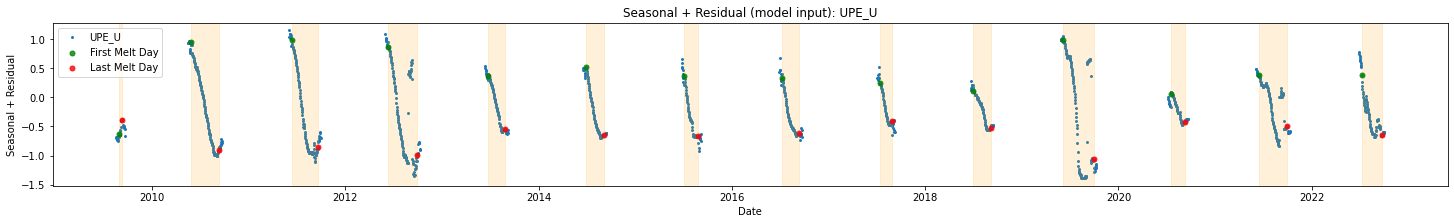

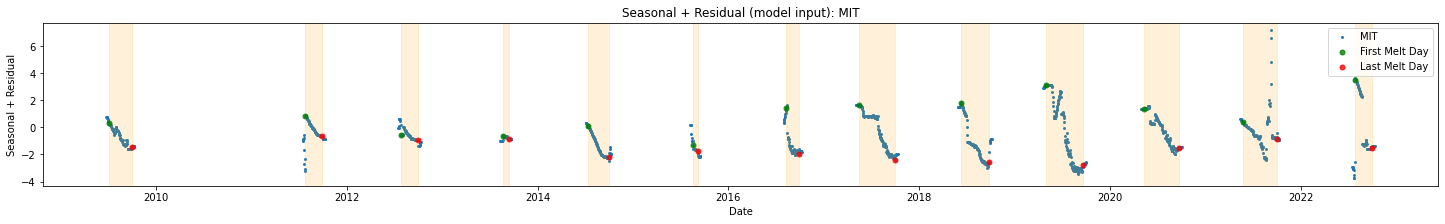

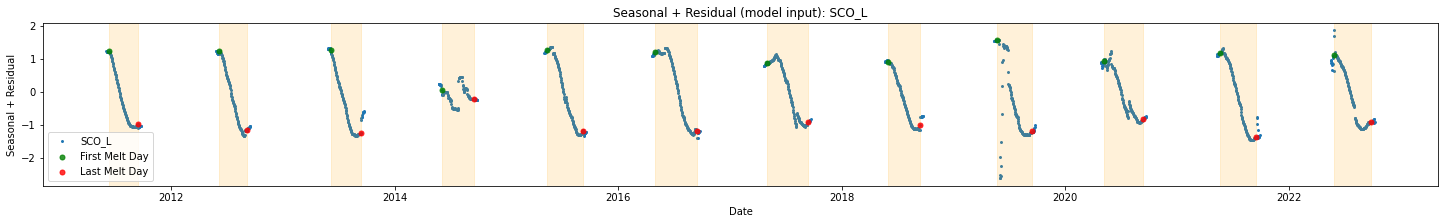

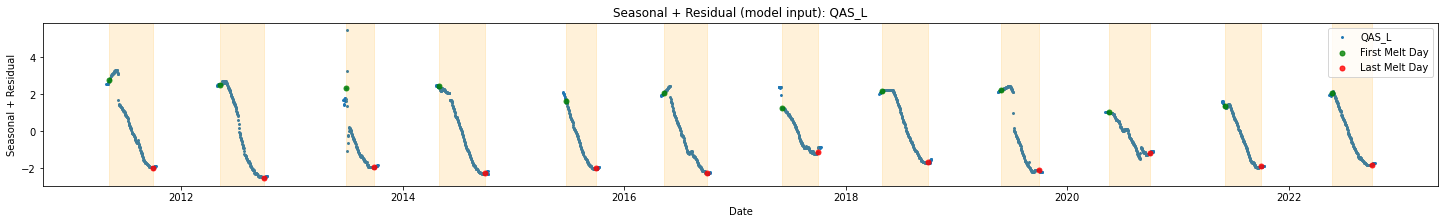

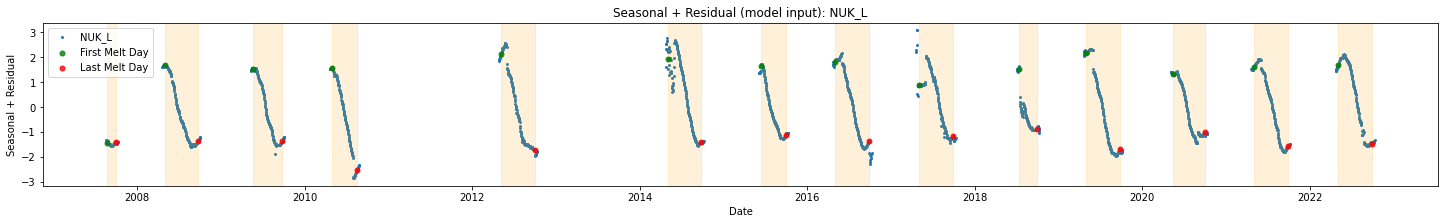

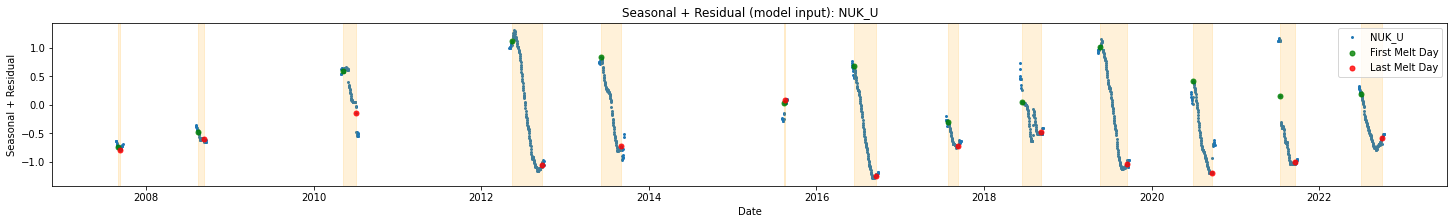

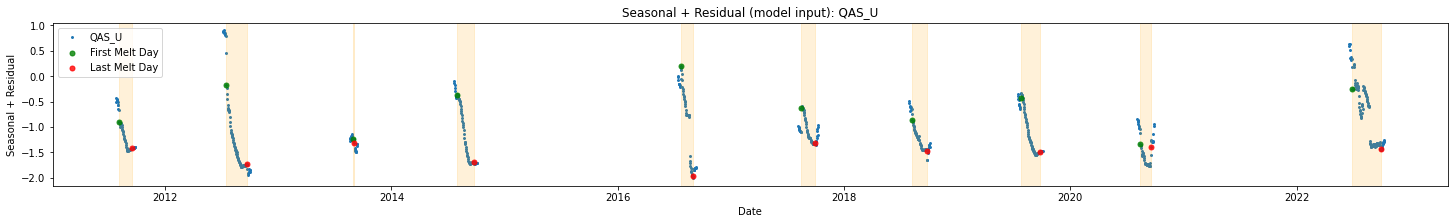

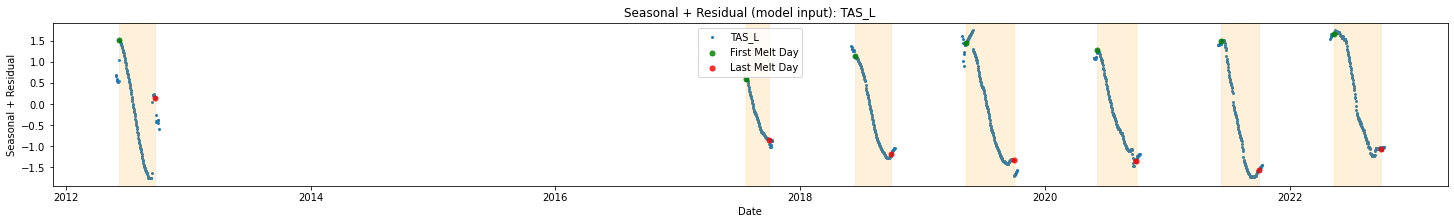

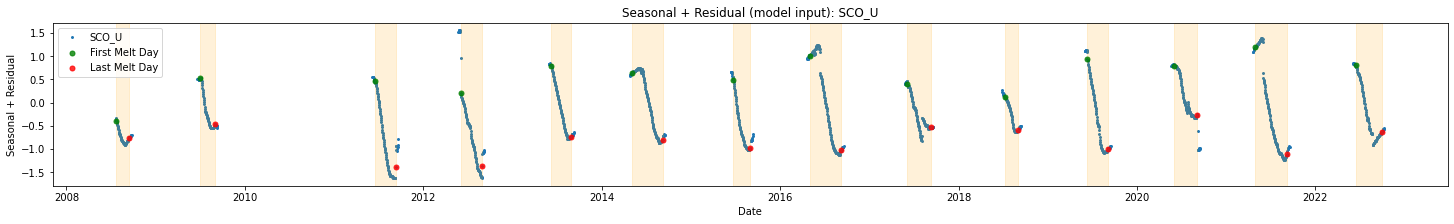

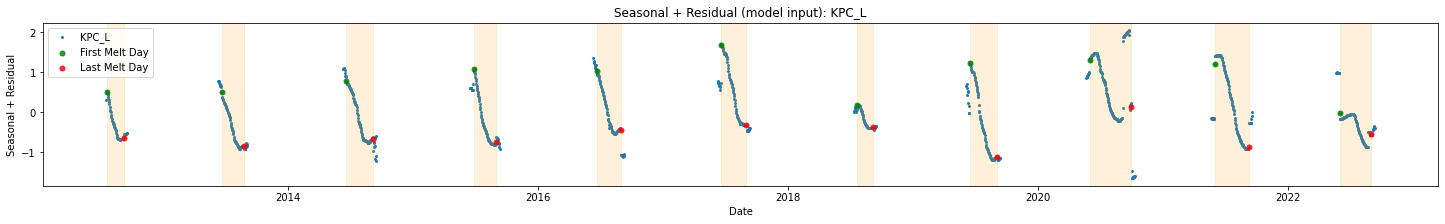

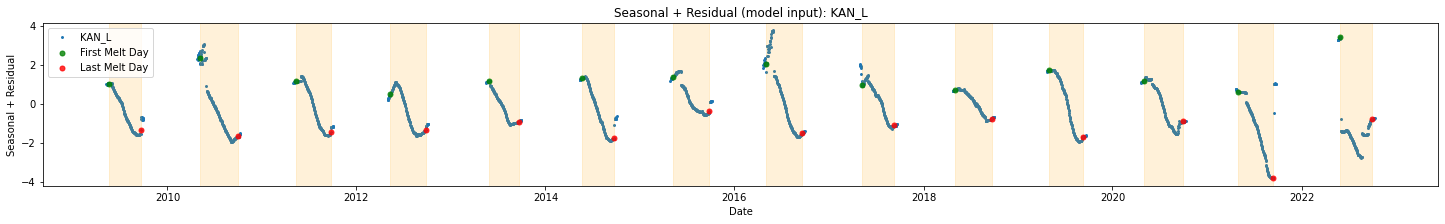

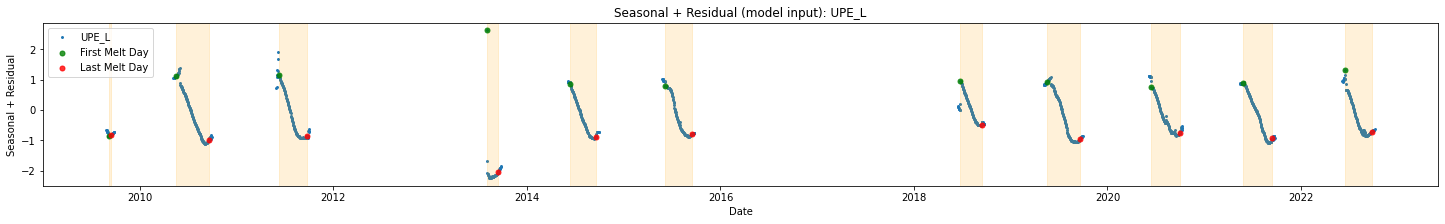

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

for stid in ablation_df['stid'].unique():
    station_df = df[df['stid'] == stid]
    # filter the dataframe to only include rows where ablation occurred
    ablation_df = df[df['Ablation'] == True]

    # create a line plot for each station, highlighting the periods of ablation
    fig, ax = plt.subplots(figsize=(25,3))
    station_df = df[df['stid'] == stid]
    
    # Plot the blue scatter points
    plt.scatter(station_df['Datetime'], station_df['seasonal_residual'], c='C0',  marker='.', label=stid, s=15)
    
    first_melt_days = station_df[station_df['first_melt_day'] == True]['Datetime']
    last_melt_days = station_df[station_df['last_melt_day'] == True]['Datetime']
    
    for first_day, last_day in zip(first_melt_days, last_melt_days):
        ax.axvspan(first_day, last_day, alpha=0.15, color='orange')
    
    # Plot the first melt day values
    plt.scatter(first_melt_days, station_df.loc[first_melt_days.index, 'seasonal_residual'], c='g', alpha=0.8, marker='.', label='First Melt Day', s=100)
    
    # Plot the last melt day values
    plt.scatter(last_melt_days, station_df.loc[last_melt_days.index, 'seasonal_residual'], c='r', alpha=0.8 , marker='.', label='Last Melt Day', s=100)

    # set plot title, axis labels and legend
    ax.set_title(f'Seasonal + Residual (model input): {stid}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Seasonal + Residual')
    ax.legend()
    
    # Save the plot in the Downloads folder
    #plot_filename = f'seasonal_residual_model_{stid}.png'
    #plt.savefig(os.path.join(os.path.expanduser("~"), "Downloads", plot_filename), dpi=300)
    
plt.show()


##### Pre-processing (2.0: Formatting and transformation)

In [25]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
df['stid'] = le.fit_transform(df['stid'])
station_names = dict(zip(le.classes_, le.transform(le.classes_)))

In [26]:
# This bit to include only relevant features
exclude_list = ['index', # excluded because of unimportant information
                #'stid', 
                'Unnamed: 0', # Old Index
                'Wind from direction (upper boom)',
          #      'Ablation',
                'Melting Season', # We drop melting season later 
                'month',
                'month_sin',
                'month_cos',
                'day', 
                'day_sin',
                'day_cos',
                'hour', 
                'year',
                'year_sin',
                'year_cos'
                'subgroup',
                'Surface height from combined measurements',
                'Surface height from combined measurements DELTA',
                'observed', 
                'residual', 
                'seasonal', 
                'trend',
                'residual_smoothed',
                'Periods',
                'Year',
             #   'first_melt_day',
             #   'last_melt_day',
                'DayOfYear',
              #  'Datetime',
                #'seasonal_residual'
               ]



df = df[[column for column in df.columns if column not in exclude_list]]
data = df.copy()

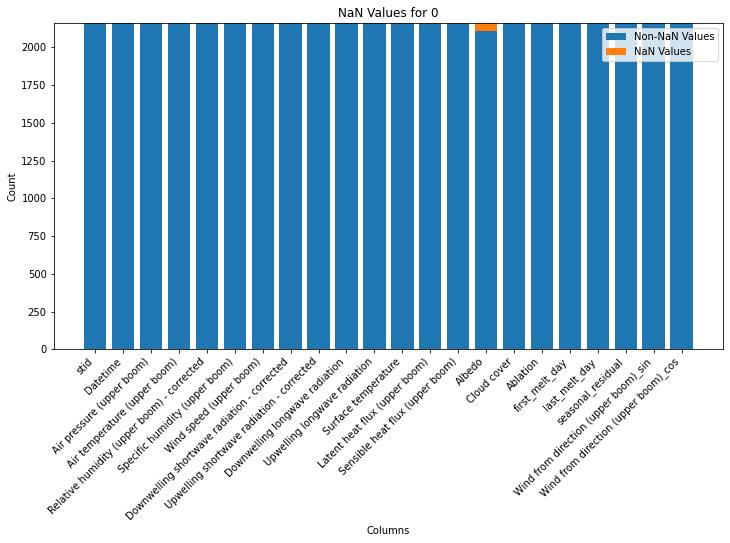

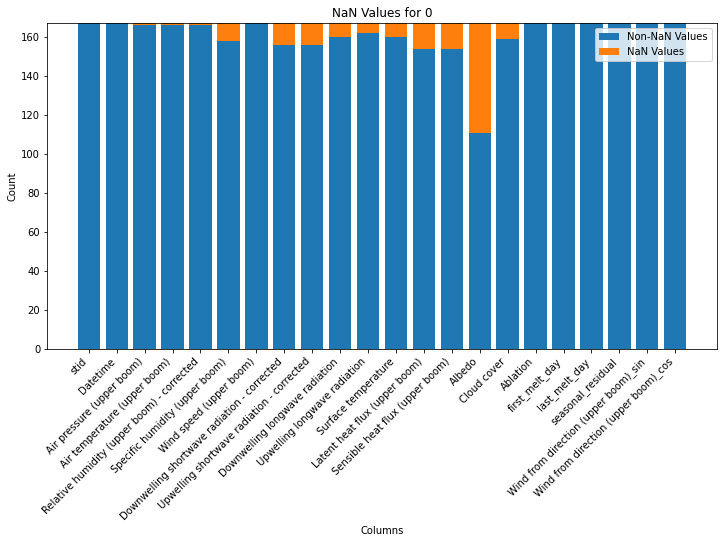

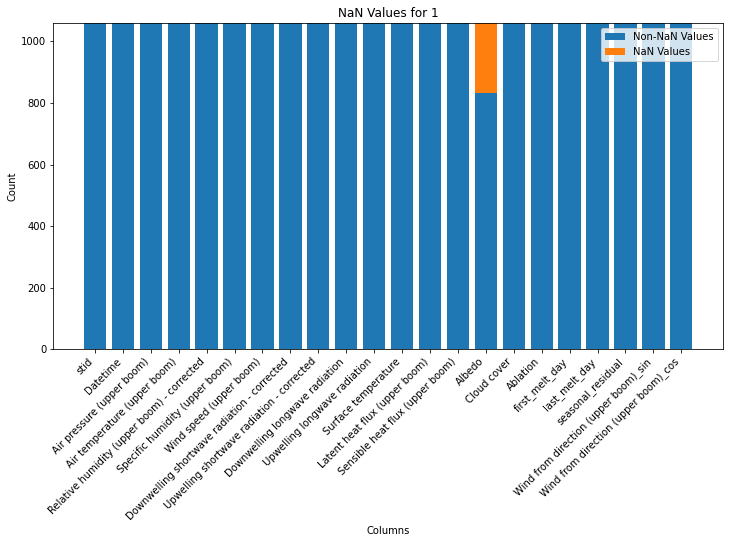

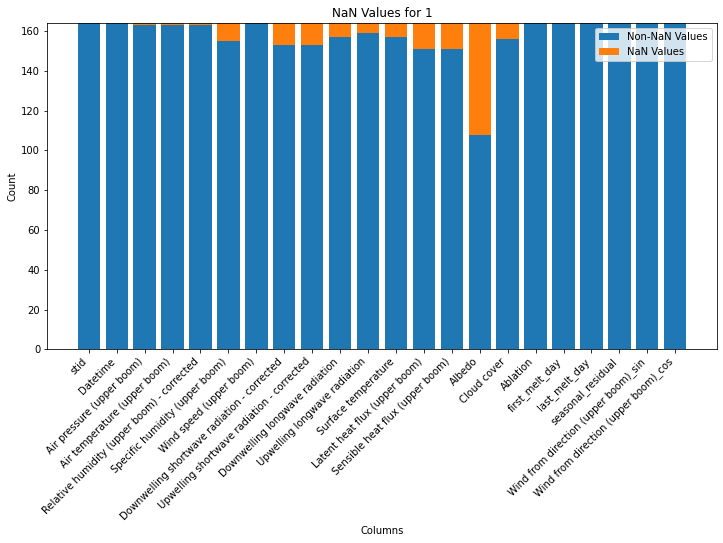

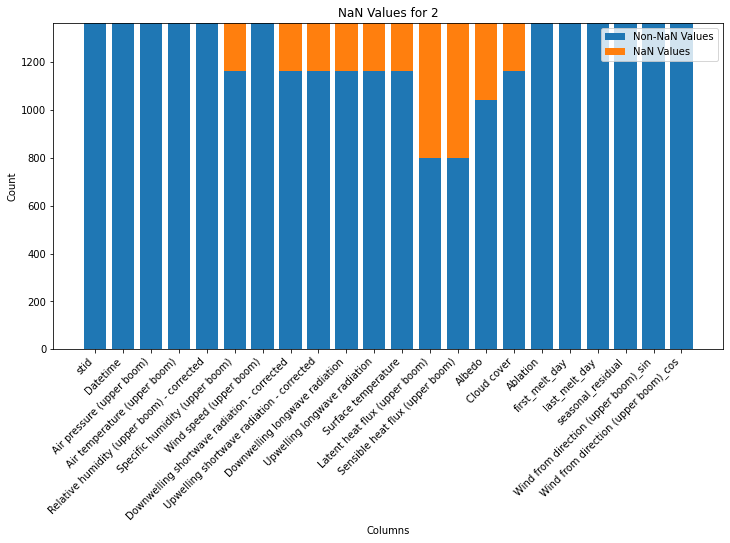

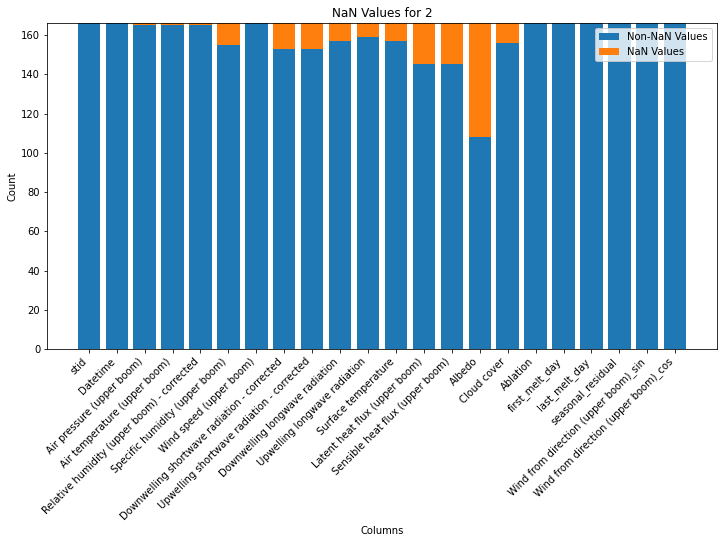

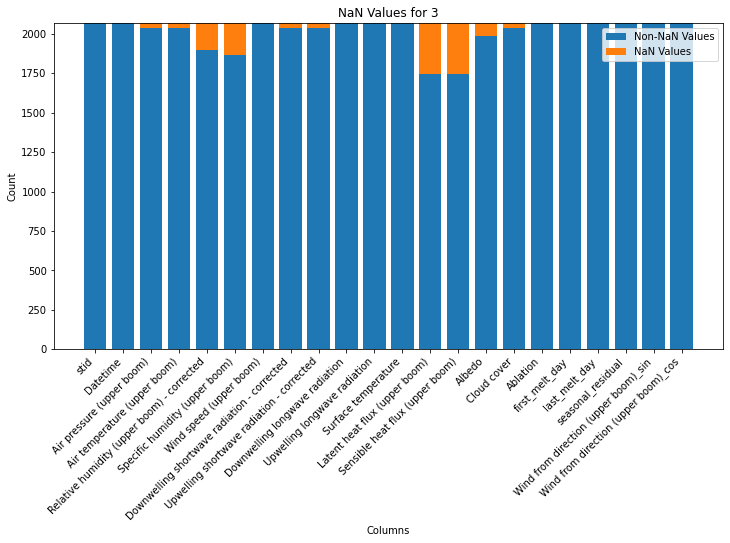

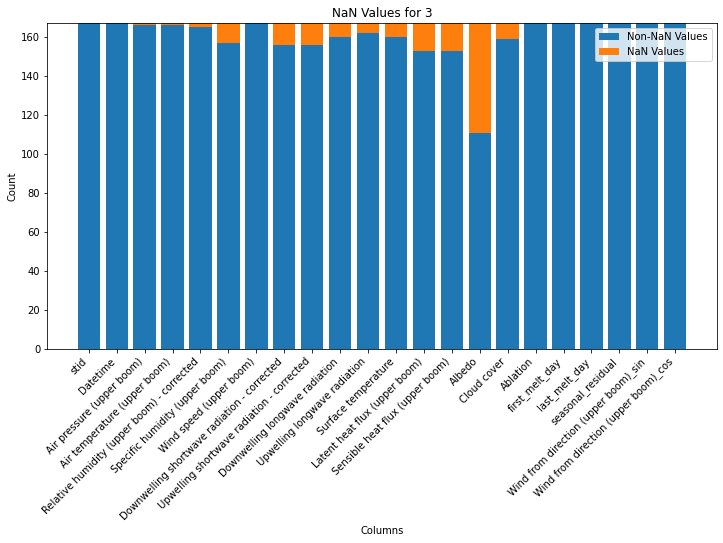

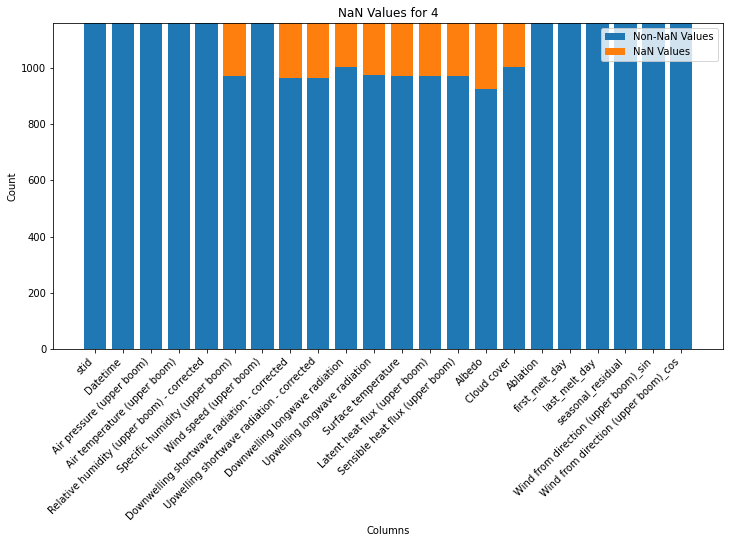

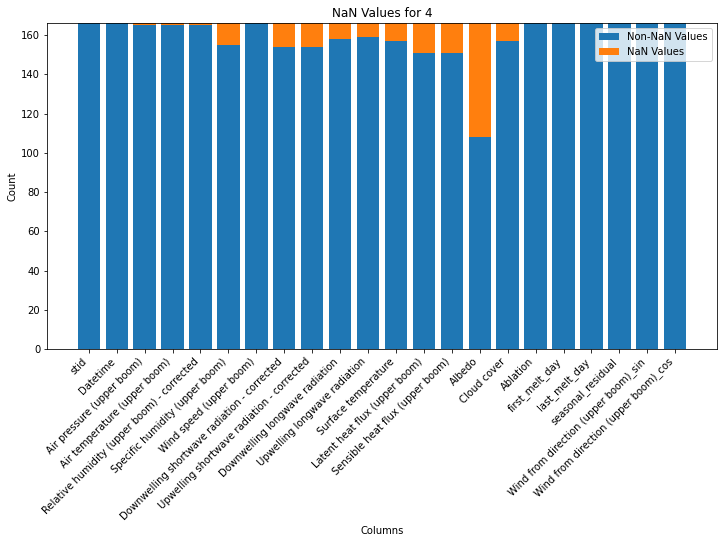

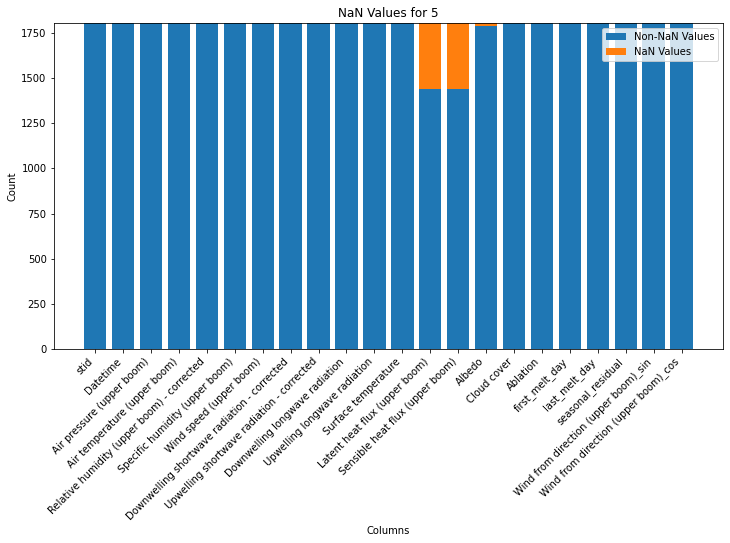

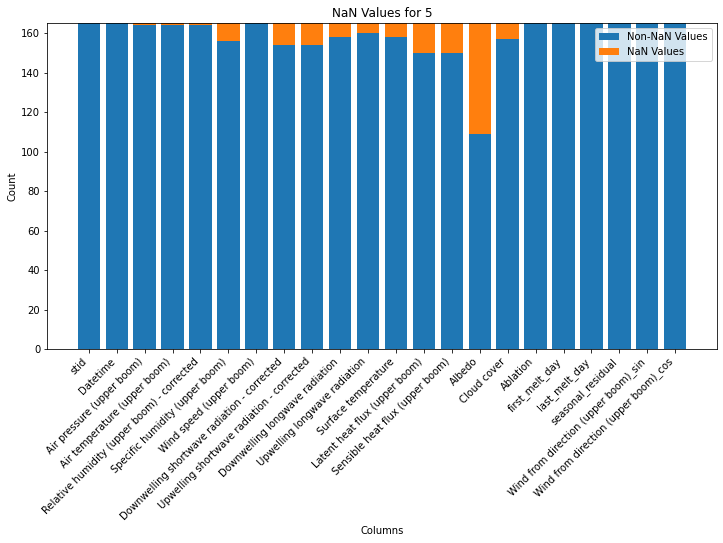

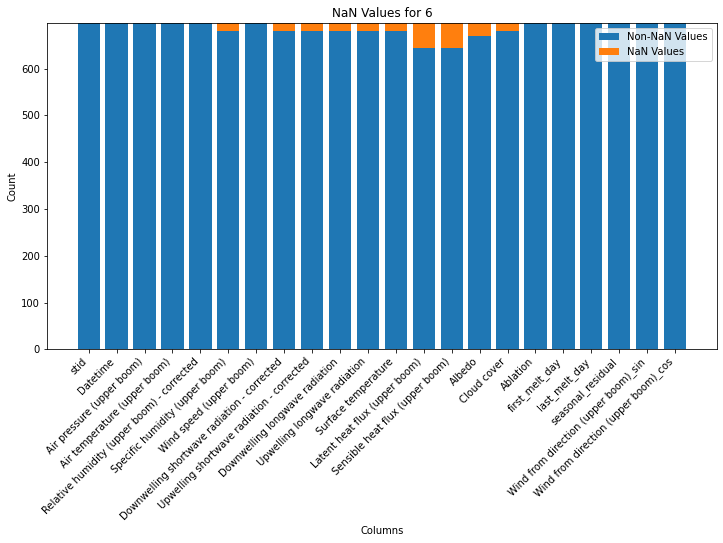

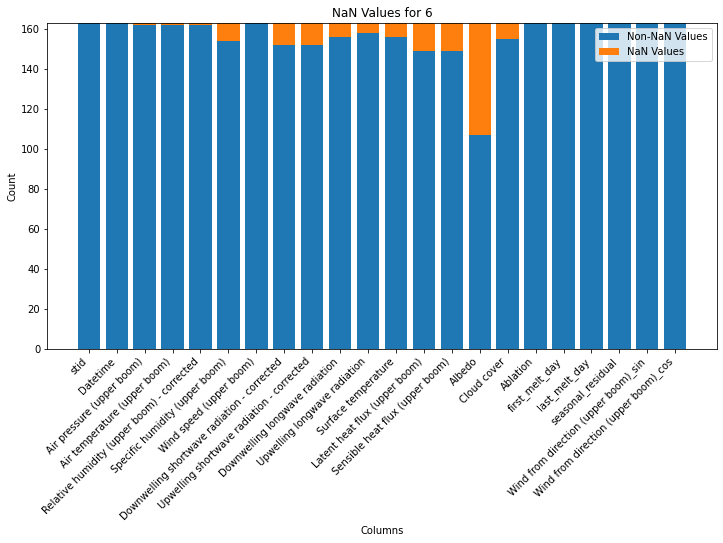

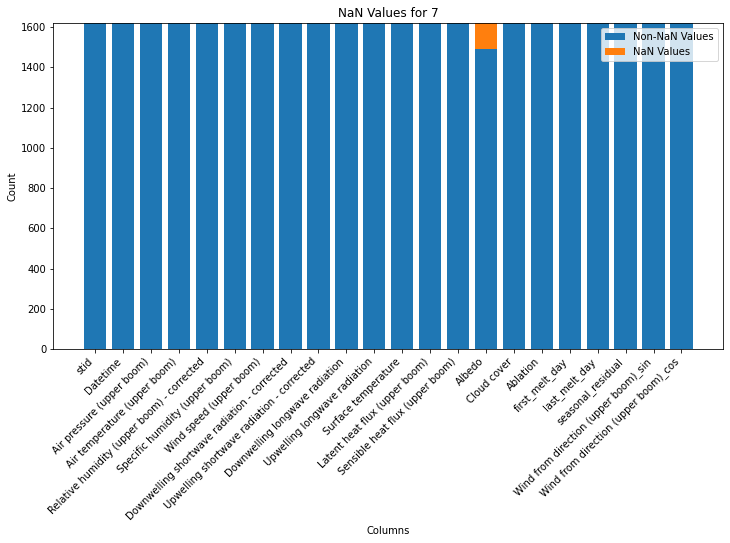

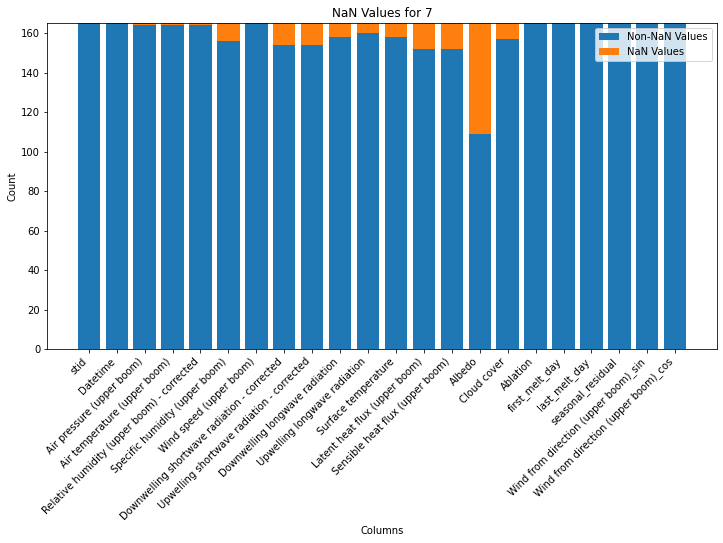

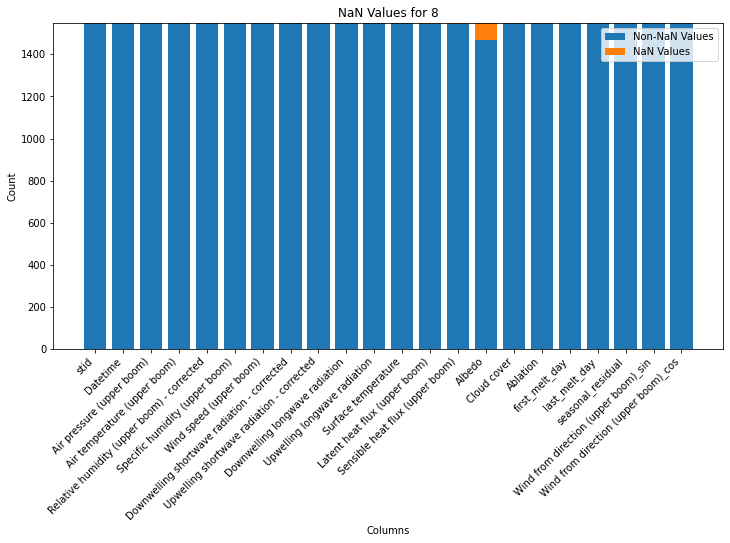

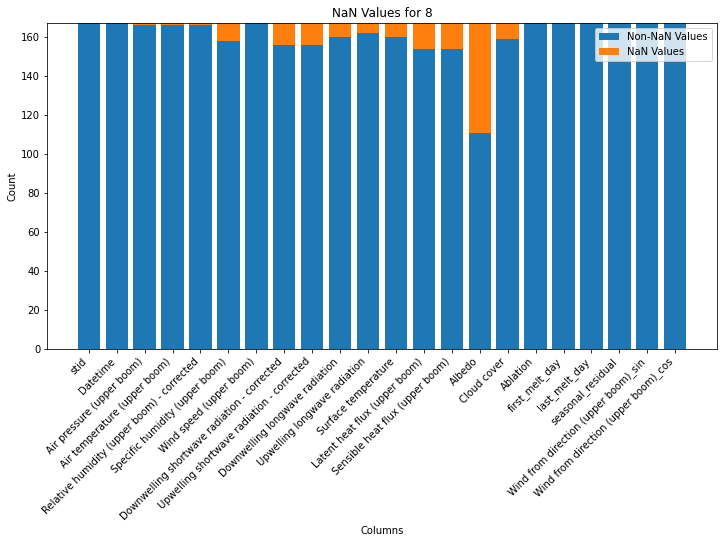

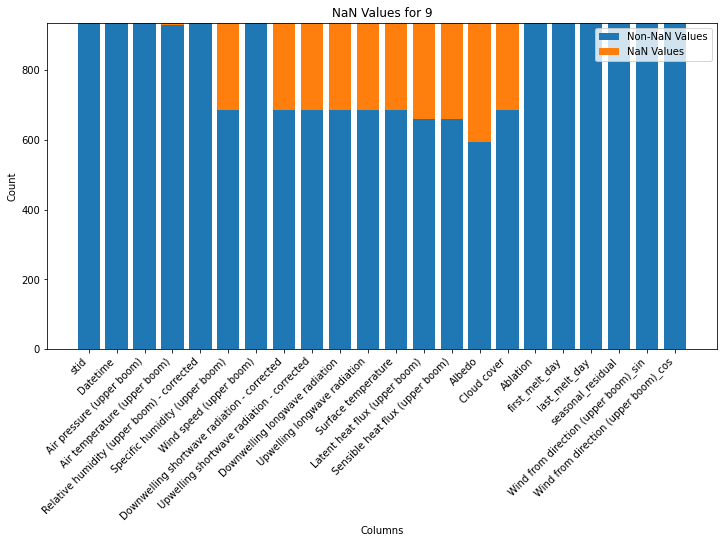

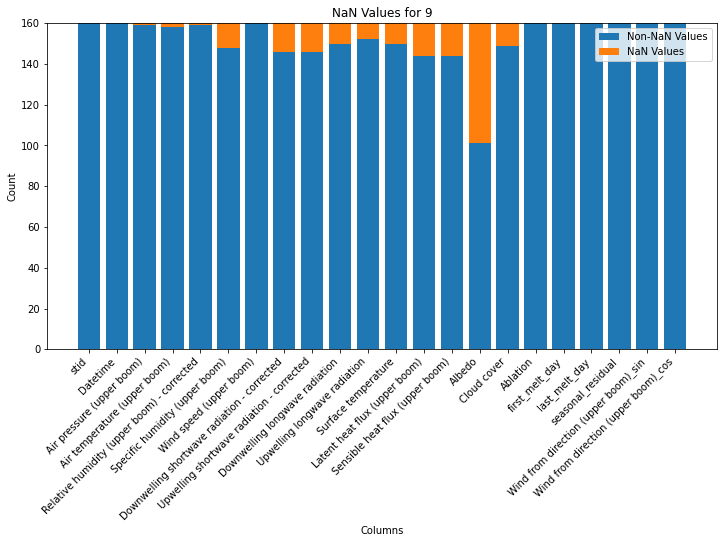

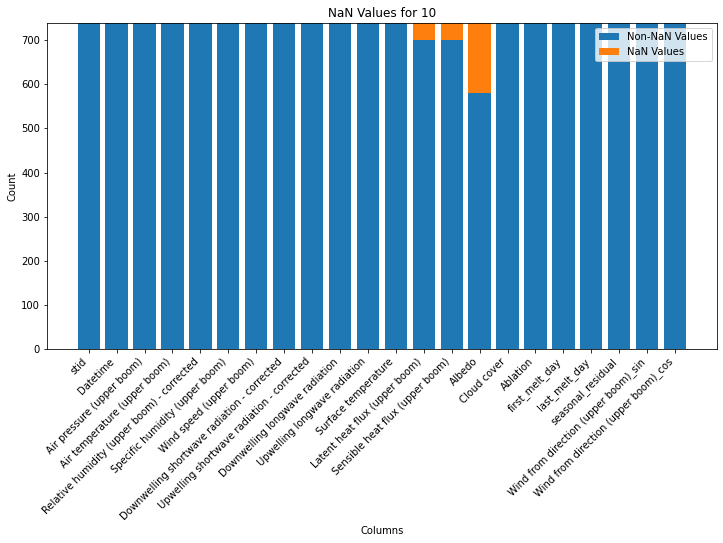

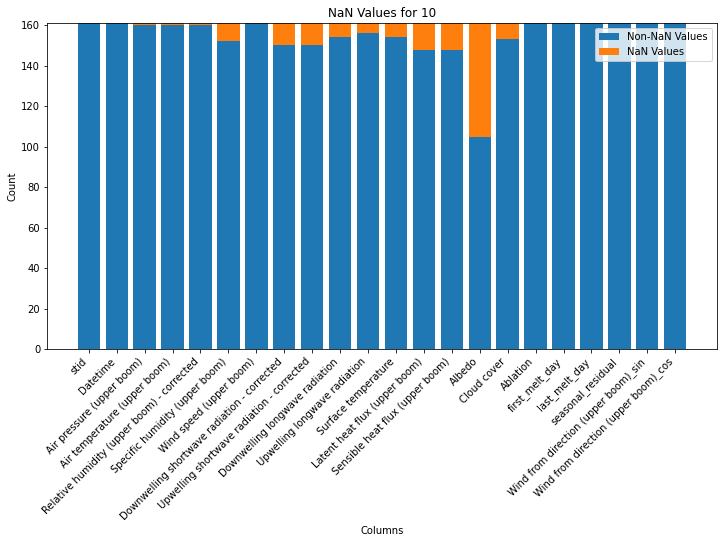

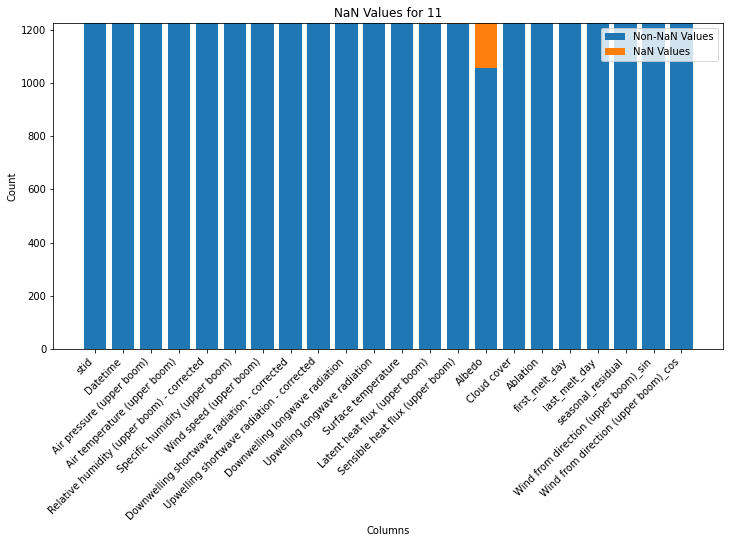

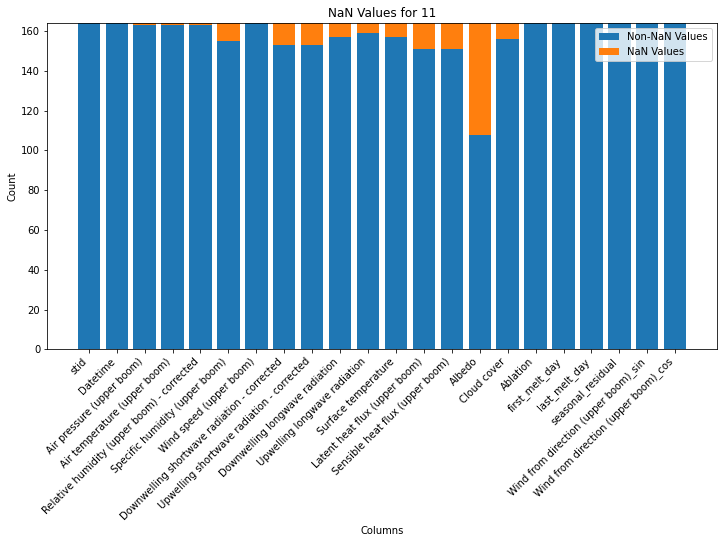

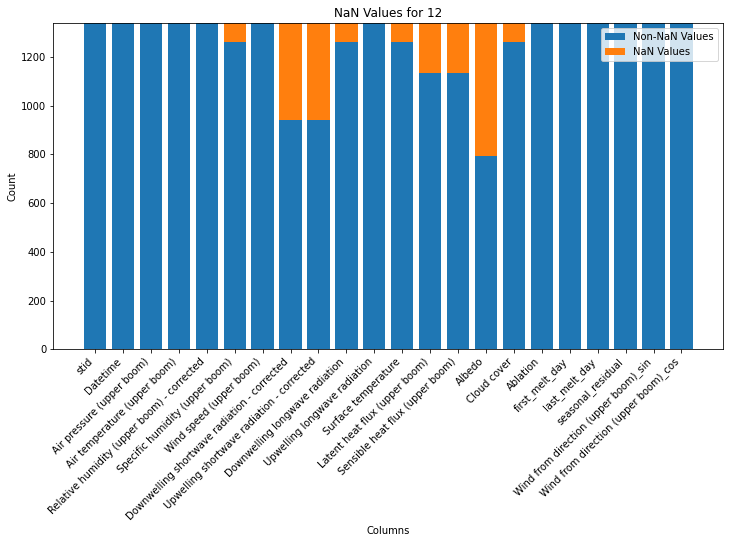

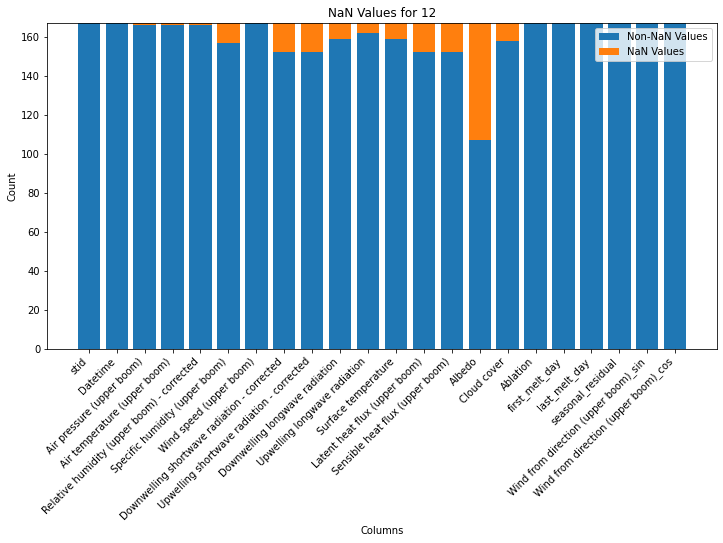

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

for stid in df['stid'].unique():
    station_df = df[df['stid'] == stid]
    ablation_df = station_df[station_df['Ablation'] == True]
    
    # Plot 1: Bar plot with total count of observations and NaN values as stacked bars
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    nan_counts = station_df.isna().sum()
    non_nan_counts = station_df.notna().sum()
    
    ax1.bar(nan_counts.index, non_nan_counts, label='Non-NaN Values')
    ax1.bar(nan_counts.index, nan_counts, bottom=non_nan_counts, label='NaN Values')
    
    ax1.set_title(f'NaN Values for {stid}')
    ax1.set_xlabel('Columns')
    ax1.set_ylabel('Count')
    ax1.legend()
    
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    station_df = df[(df['stid'] == stid) & (df['first_melt_day'] == True) | (df['last_melt_day'] == True)]
    ablation_df = station_df[station_df['Ablation'] == True]
    
    # Plot 1: Bar plot with total count of observations and NaN values as stacked bars
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    nan_counts = station_df.isna().sum()
    non_nan_counts = station_df.notna().sum()
    
    ax1.bar(nan_counts.index, non_nan_counts, label='Non-NaN Values')
    ax1.bar(nan_counts.index, nan_counts, bottom=non_nan_counts, label='NaN Values')
    
    ax1.set_title(f'NaN Values for {stid}')
    ax1.set_xlabel('Columns')
    ax1.set_ylabel('Count')
    ax1.legend()
    
    plt.xticks(rotation=45, ha='right')
    plt.show()
    

In [28]:
# Initialize an empty DataFrame to store the results
nan_summary = pd.DataFrame(columns=['Non-NaN Values', 'NaN Values'])

# Create a multi-level index for the summary DataFrame
multi_index = pd.MultiIndex(levels=[[], [], []], codes=[[], [], []], names=['stid', 'descriptor', 'column'])
nan_summary.index = multi_index

for stid in df['stid'].unique():
    # For the entire dataset
    station_df = df[df['stid'] == stid]
    non_nan_counts = station_df.notna().sum()
    nan_counts = station_df.isna().sum()
    
    # Save the counts in the summary DataFrame
    for col in non_nan_counts.index:
        nan_summary.loc[(stid, 'total', col), 'Non-NaN Values'] = non_nan_counts[col]
        nan_summary.loc[(stid, 'total', col), 'NaN Values'] = nan_counts[col]
    
    # For the ablation period only
    station_df = df[((df['stid'] == stid) & (df['first_melt_day'] == True)) | (df['last_melt_day'] == True)]
    non_nan_counts = station_df.notna().sum()
    nan_counts = station_df.isna().sum()
    
    # Save the counts in the summary DataFrame
    for col in non_nan_counts.index:
        nan_summary.loc[(stid, 'Melt Onset Day/ Melt End Day', col), 'Non-NaN Values'] = non_nan_counts[col]
        nan_summary.loc[(stid, 'Melt Onset Day/ Melt End Day', col), 'NaN Values'] = nan_counts[col]



In [29]:
import textwrap

def format_dataframe(nan_summary):
    formatted_df = nan_summary.reset_index()
    formatted_df = formatted_df[formatted_df['descriptor'] == 'total'].drop(columns=['descriptor', 'Non-NaN Values'])

    all_training_count = sum(formatted_df['NaN Values'])
    melt_count = sum(formatted_df[formatted_df['column'].isin(['first_melt_day', 'last_melt_day'])]['NaN Values'])

    formatted_df['All Training Instances'] = formatted_df['NaN Values'].apply(lambda x: x)
    formatted_df['Melt Onset Day/ Melt End Day'] = formatted_df['NaN Values'].apply(lambda x: x)

    formatted_df = formatted_df.drop(columns=['NaN Values'])
    formatted_df.columns = ['stid', 'Column', 'All Training Instances', 'Melt Onset Day/ Melt End Day']
    formatted_df = formatted_df.set_index(['stid', 'Column'])
    formatted_df = formatted_df[(formatted_df['All Training Instances'] > 0) | (formatted_df['Melt Onset Day/ Melt End Day'] > 0)]
    return formatted_df

formatted_df = format_dataframe(nan_summary)
all_training_count = df['first_melt_day'].count()
melt_count = df[(df['first_melt_day'] == True) | (df['last_melt_day'] == True)]
melt_count = melt_count['first_melt_day'].count()

def create_latex_table(formatted_df, all_training_count, melt_count):
    latex_table = textwrap.dedent(fr"""
        \begin{{table}}[H]
        \label{{tab:: NaN values of SCO_L}}
        \centering
        \begin{{tabularx}}{{\linewidth}}{{
          |c
           |>{{\hsize=4\hsize}}c
          |>{{\hsize=8\hsize}}c
          |>{{\hsize=4\hsize}}c|
        }}
        \toprule
         & \thead{{\textbf{{Total Training ({all_training_count})}}}} & \thead{{\textbf{{Melt Onset \& Melt End Day ({melt_count})}}}} \\
        \midrule
        & NaN  values & NaN  values \\
        \midrule
    """)

    for index, row in formatted_df.iterrows():
        latex_table += f"{index[1]} & {row['All Training Instances']} & {row['Melt Onset Day/ Melt End Day']} \\\\\n"

    latex_table += r"""
        \end{tabularx}
        \caption{NaN values of SCO_L}
        \end{table}
    """

    return latex_table

print(create_latex_table(formatted_df, all_training_count, melt_count))



\begin{table}[H]
\label{tab:: NaN values of SCO_L}
\centering
\begin{tabularx}{\linewidth}{
  |c
   |>{\hsize=4\hsize}c
  |>{\hsize=8\hsize}c
  |>{\hsize=4\hsize}c|
}
\toprule
 & \thead{\textbf{Total Training (17710)}} & \thead{\textbf{Melt Onset \& Melt End Day (306)}} \\
\midrule
& NaN  values & NaN  values \\
\midrule
Latent heat flux (upper boom) & 4 & 4 \\
Sensible heat flux (upper boom) & 4 & 4 \\
Albedo & 54 & 54 \\
Latent heat flux (upper boom) & 1 & 1 \\
Sensible heat flux (upper boom) & 1 & 1 \\
Albedo & 227 & 227 \\
Specific humidity (upper boom) & 200 & 200 \\
Downwelling shortwave radiation - corrected & 201 & 201 \\
Upwelling shortwave radiation - corrected & 201 & 201 \\
Downwelling longwave radiation & 200 & 200 \\
Upwelling longwave radiation & 200 & 200 \\
Surface temperature & 200 & 200 \\
Latent heat flux (upper boom) & 563 & 563 \\
Sensible heat flux (upper boom) & 563 & 563 \\
Albedo & 319 & 319 \\
Cloud cover & 200 & 200 \\
Air pressure (upper boom) & 32 & 32 \\

In [30]:
# This bit to include only relevant features
exclude_list = ['index', # excluded because of unimportant information
                #'stid', 
                'Unnamed: 0', # Old Index
                'Wind from direction (upper boom)',
                'Ablation',
                'Melting Season', # We drop melting season later 
                'month',
                'month_sin',
                'month_cos',
                'day', 
                'day_sin',
                'day_cos',
                'hour', 
                'year',
                'year_sin',
                'year_cos'
                'subgroup',
                'Surface height from combined measurements',
                'Surface height from combined measurements DELTA',
                'observed', 
                'residual', 
                'seasonal', 
                'trend',
                'residual_smoothed',
                'Periods',
                'Year',
                'first_melt_day',
                'last_melt_day',
                'DayOfYear',
                'Datetime',
                #'seasonal_residual'
               ]



df = df[[column for column in df.columns if column not in exclude_list]]
data = df.copy()

In [31]:
# This bit to convert all numerical values into the same scale 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# Exclude whater is not needed for scaling
exlude_num = ['stid', 
              'Surface height from combined measurements', 
              'Surface height from combined measurements DELTA',
              'month_sin',
              'month_cos',
              'month',
              'day', 
              'day_sin',
              'day_cos',
              'hour', 
              'year',
              'year_sin',
              'year_cos'
              'subgroup',
              'Surface height from combined measurements',
              'Surface height from combined measurements DELTA',
              'observed', 
              'residual', 
              'seasonal', 
              'trend',
              'Wind from direction (upper boom)',
              'Wind from direction (upper boom)_sin',
              'Wind from direction (upper boom)_cos',
              'seasonal_residual',
              'residual_smoothed',
              'Datetime',
             ]


num_cols = df.select_dtypes(include=['int64','float64'])
num_cols = num_cols[[column for column in num_cols.columns if column not in exlude_num]].columns

scaler = MinMaxScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])
data[num_cols] = scaler.fit_transform(data[num_cols])

df['seasonal_residual'] = scaler.fit_transform(df['seasonal_residual'].values.reshape(-1, 1))
data['seasonal_residual'] = scaler.fit_transform(data['seasonal_residual'].values.reshape(-1, 1))

In [32]:
## This bit only for baseline models
df_base = df
df_base['Albedo'] = df_base['Albedo'].fillna(method='bfill')
df_base = df_base.dropna()

from sklearn.model_selection import train_test_split

# Get unique stid values
stid_values = df_base['stid'].unique()

# Initialize empty lists to store train and test data
X_train, X_test, y_train, y_test = [], [], [], []

# Loop through each stid value and split the data into train and test sets
for stid in stid_values:
    # Get rows corresponding to the current stid value
    subset_df_base = df_base[df_base['stid'] == stid]
    
    # Split the subset into train and test sets
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
        subset_df_base.drop([y], axis=1), subset_df_base[y], test_size=0.3, random_state=123, shuffle =True)
    
    # Append the train and test data to the lists
    X_train.append(X_train_subset)
    X_test.append(X_test_subset)
    y_train.append(y_train_subset)
    y_test.append(y_test_subset)

# Concatenate the train and test data into a single dataframe
X_train_base = pd.concat(X_train)
X_test_base = pd.concat(X_test)
y_train_base = pd.concat(y_train)
y_test_base = pd.concat(y_test)

In [33]:
# Get unique stid values
stid_values = df['stid'].unique()

# Initialize empty lists to store train and test data
X_train, X_test, y_train, y_test = [], [], [], []

# Loop through each stid value and split the data into train and test sets
for stid in stid_values:
    # Get rows corresponding to the current stid value
    subset_df = df[df['stid'] == stid]
    
    # Split the subset into train and test sets
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
        subset_df.drop([y], axis=1), subset_df[y], test_size=0.3, random_state=123, shuffle =True)
    
    # Append the train and test data to the lists
    X_train.append(X_train_subset)
    X_test.append(X_test_subset)
    y_train.append(y_train_subset)
    y_test.append(y_test_subset)

# Concatenate the train and test data into a single dataframe
X_train = pd.concat(X_train)
X_test = pd.concat(X_test)
y_train = pd.concat(y_train)
y_test = pd.concat(y_test)

In [34]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)

## Regression Modelling

-------

## Selected Models

In [35]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_hist_gradient_boosting  # Required to enable HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
import xgboost as xgb
from sklearn.metrics import r2_score
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [36]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [37]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    for ii, (tr, tt) in enumerate(cv.split(X, y)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + 0.5] * len(indices), c=indices, marker="_", lw=lw, cmap=plt.cm.coolwarm, vmin=-0.2, vmax=1.2)

    ax.set_xlabel("Sample index")
    ax.set_ylabel("CV iteration")
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.set_title("{}".format(type(cv).__name__))
    return ax

In [38]:
def plot_validation_curve(estimator, title, X, y, param_name, param_range, cv=None, n_jobs=-1, log_scale=False):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, n_jobs=n_jobs)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel(f"{param_name}")
    plt.ylabel("Score")
    plt.grid()

    if log_scale:
        plt.xscale("log")

    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Linear Regression MSE: 0.0746930007495984


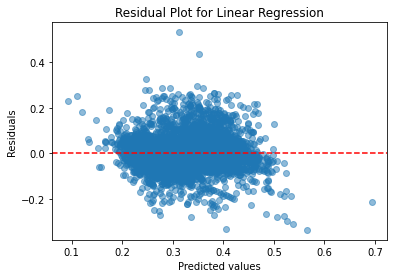

------------------------------------------------------------------------------------
KAN_L
R^2 score on test set (seasonal_residual):  0.4038863555753126
MSE on test set (seasonal_residual):  0.08917314580091514


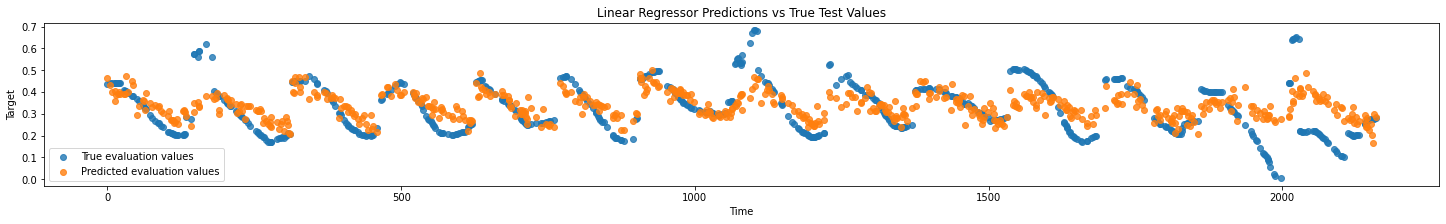

------------------------------------------------------------------------------------
KPC_L
R^2 score on test set (seasonal_residual):  0.22033886857999663
MSE on test set (seasonal_residual):  0.05871127564973594


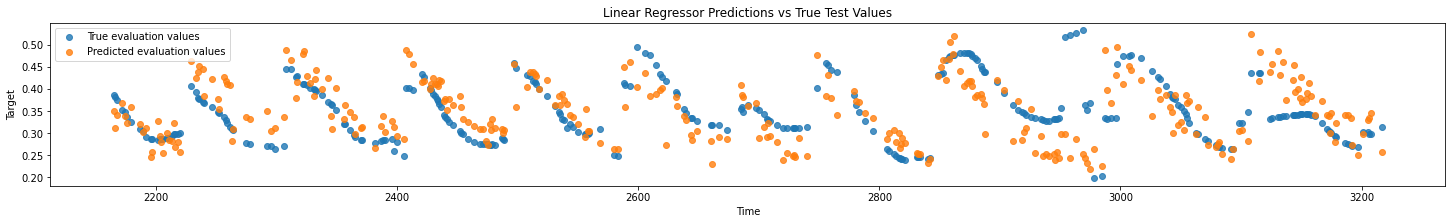

------------------------------------------------------------------------------------
MIT
R^2 score on test set (seasonal_residual):  0.16569107645006476
MSE on test set (seasonal_residual):  0.09545660971015872


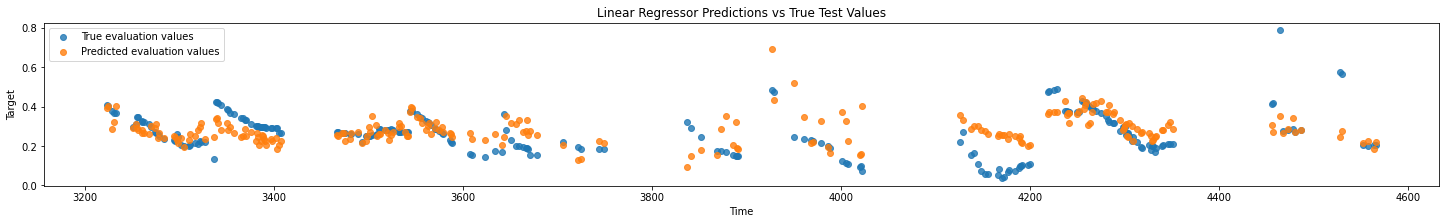

------------------------------------------------------------------------------------
NUK_L
R^2 score on test set (seasonal_residual):  0.3534138351753727
MSE on test set (seasonal_residual):  0.09649613421932077


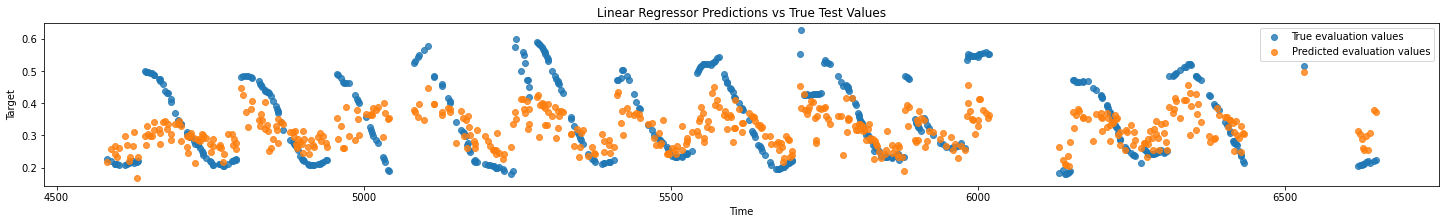

------------------------------------------------------------------------------------
NUK_U
R^2 score on test set (seasonal_residual):  0.3513503197602571
MSE on test set (seasonal_residual):  0.049229330576115664


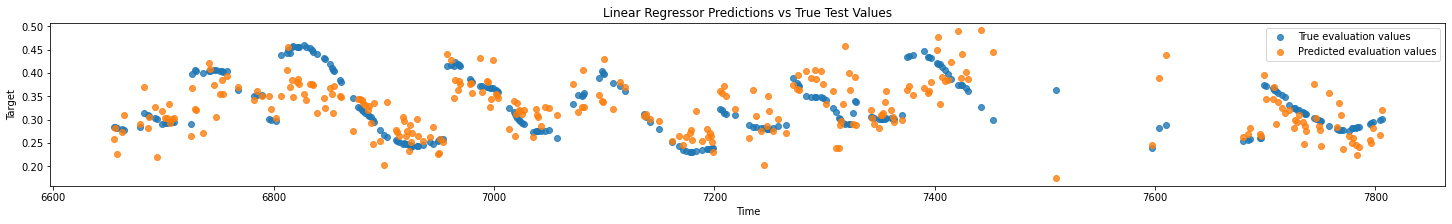

------------------------------------------------------------------------------------
QAS_L
R^2 score on test set (seasonal_residual):  0.4769171005683316
MSE on test set (seasonal_residual):  0.10994720542206844


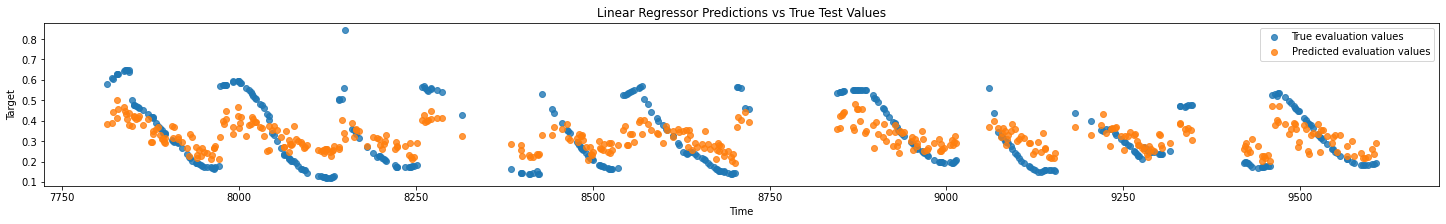

------------------------------------------------------------------------------------
QAS_U
R^2 score on test set (seasonal_residual):  -0.4436098071549497
MSE on test set (seasonal_residual):  0.060603254126260775


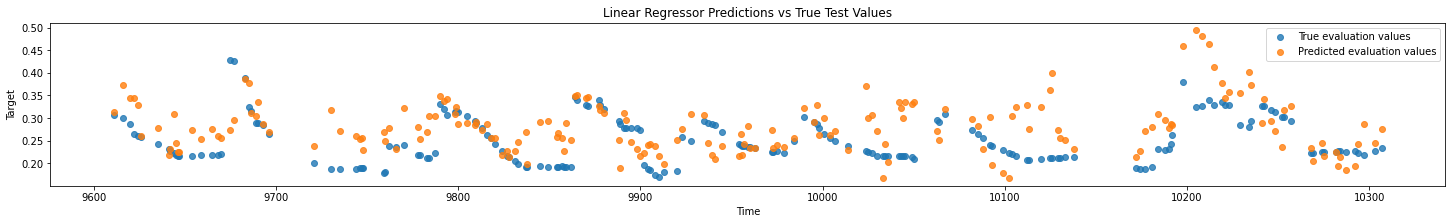

------------------------------------------------------------------------------------
SCO_L
R^2 score on test set (seasonal_residual):  0.6346322624044656
MSE on test set (seasonal_residual):  0.04993325676980529


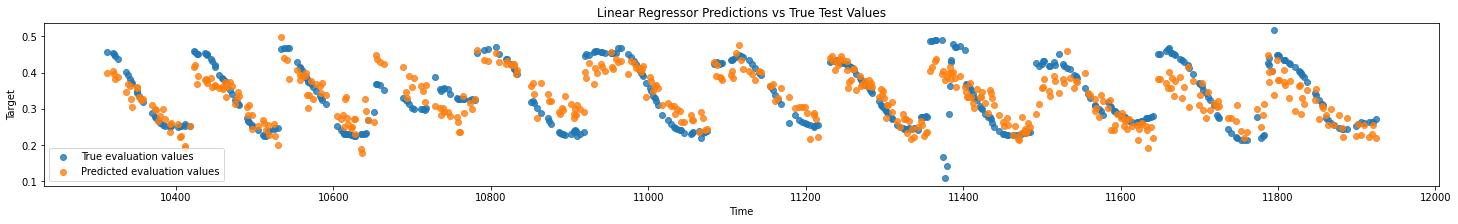

------------------------------------------------------------------------------------
SCO_U
R^2 score on test set (seasonal_residual):  0.6284774137766826
MSE on test set (seasonal_residual):  0.04053277191048901


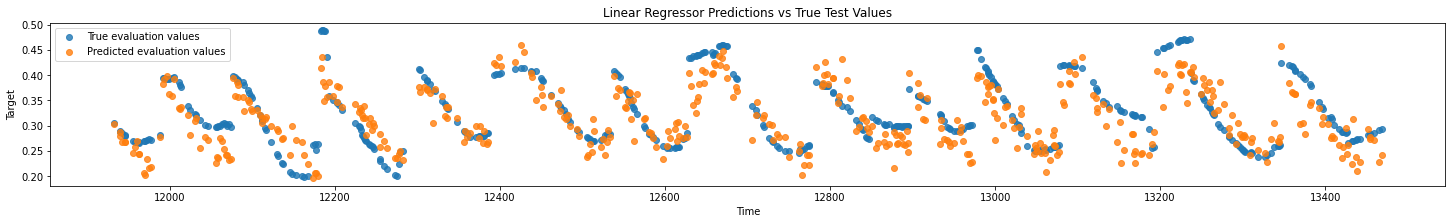

------------------------------------------------------------------------------------
TAS_L
R^2 score on test set (seasonal_residual):  0.5864967874867911
MSE on test set (seasonal_residual):  0.0601371485983715


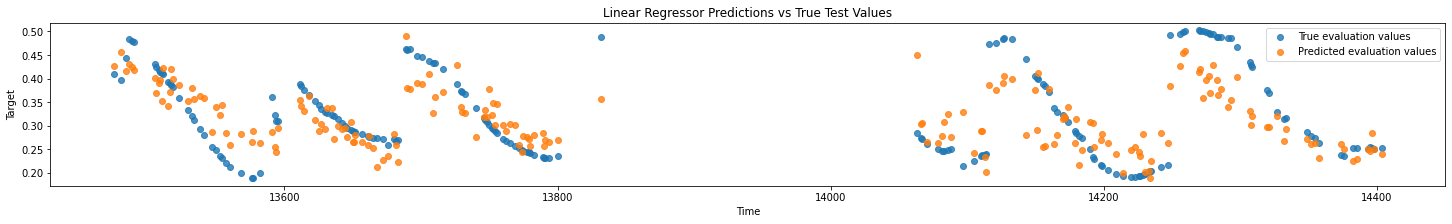

------------------------------------------------------------------------------------
THU_L
R^2 score on test set (seasonal_residual):  0.33450026796189647
MSE on test set (seasonal_residual):  0.04449055916188453


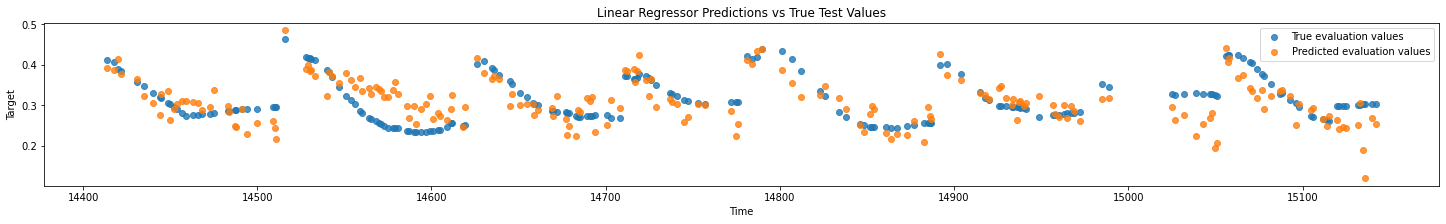

------------------------------------------------------------------------------------
UPE_L
R^2 score on test set (seasonal_residual):  0.32276416608464487
MSE on test set (seasonal_residual):  0.060618678781257644


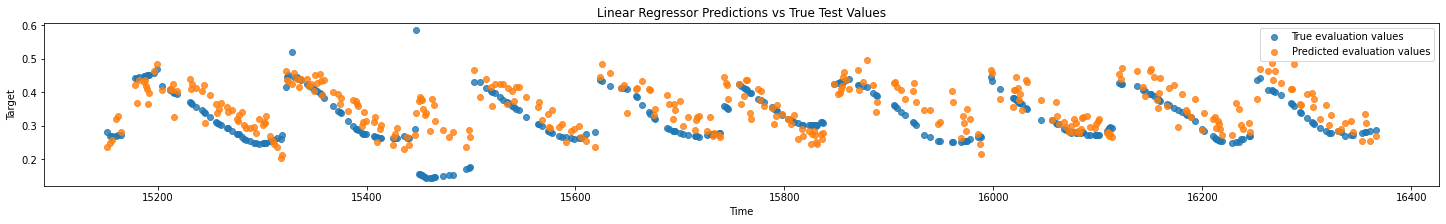

------------------------------------------------------------------------------------
UPE_U
R^2 score on test set (seasonal_residual):  -1.3381797796981911
MSE on test set (seasonal_residual):  0.07339270451486375


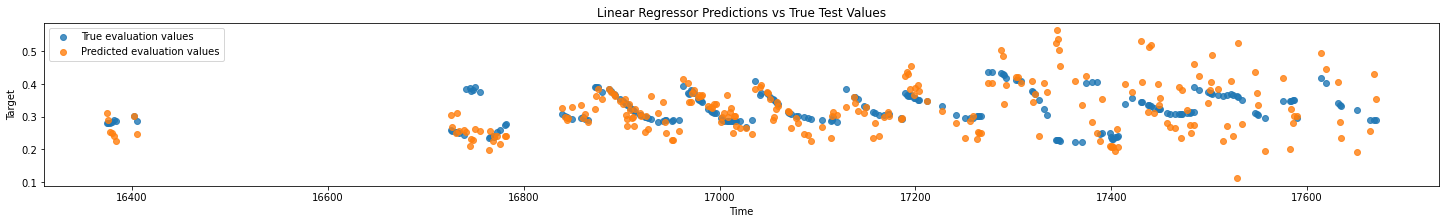

In [224]:
#Linear Regression

# Train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_base, y_train_base)

# Predict and calculate RMSE
y_pred_lr = lr_model.predict(X_test_base)
mse_lr = mean_squared_error(y_test_base, y_pred_lr, squared=False)

print("Linear Regression MSE:", mse_lr)

import matplotlib.pyplot as plt

residuals = y_test_base - y_pred_lr

plt.scatter(y_pred_lr, residuals, alpha=0.5)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Linear Regression")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train_base.loc[X_train_base['stid'] == value]
    X_test_station = X_test_base.loc[X_test_base['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train_base.loc[X_train_station.index]
    y_test_station = y_test_base.loc[X_test_station.index]

    y_pred_station = lr_model.predict(X_test_station)
    r2_station = r2_score(y_test_station, y_pred_station)
    mse_station = mean_squared_error(y_test_station, y_pred_station, squared=False)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"MSE on test set ({y}): ", mse_station)
    
    plt.figure(figsize=(25, 3))
    plt.scatter(X_test_station.index, y_test_station, label="True evaluation values", alpha=0.8)
    plt.scatter(X_test_station.index, y_pred_station, label="Predicted evaluation values", alpha=0.8)
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.title("Linear Regressor Predictions vs True Test Values")
    plt.legend()
    plt.show()

In [47]:
# XGB Regressor
model = xgb.XGBRegressor()

# Define the hyperparameter grid for tuning
param_grid ={
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [5, 7, 9, 11, 13, 15],
    'min_child_weight': [1, 2, 4, 6, 8, 10], 
    'gamma': [0, 0.1, 0.5, 0.7, 1], 
    'subsample': [0.5, 0.7, 0.8, 0.9, 1], 
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1]
}

#Old params 

#param_grid = {
#'colsample_bytree': [0.9], 'gamma': [0], 'learning_rate': [0.05], 'max_depth': [15], 'min_child_weight': [10], 'subsample': [0.8]
#}


# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=cv, n_jobs=-1, verbose=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding R^2 score on the test set
print(f"Best hyperparameters_{y}: ", grid_search.best_params_)
print('------------------------------------------------------------------------------------')
# Save the best model parameters as 'model' variable
exec(f"xgb_model_{y} = grid_search.best_estimator_")

# Evaluate the best model on the test set
y_pred = eval(f"xgb_model_{y}").predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=False)
print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])
mean_test_score = grid_search.cv_results_["mean_test_score"][0]
std_test_score = grid_search.cv_results_["std_test_score"][0]

best_estimator = grid_search.best_estimator_
param_name = 'learning_rate'
param_range = np.arange(0.01, 0.05, 0.1)
plot_validation_curve(best_estimator, "Validation Curve (XGBRegressor)", X_train, y_train, param_name, param_range, cv=cv)
plt.show()

plot_learning_curve(best_estimator, "Learning Curve (XGBRegressor)", X_train, y_train, cv=cv)
plt.show()

print('------------------------------------------------------------------------------------')
print(f"R^2 score on validation set ({y}): ", r2)
print(f"MSE on validation set ({y}): ", mse)

residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot for XGBRegressor")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = eval(f"xgb_model_{y}").predict(X_test_station)
    y_pred_station = scaler.inverse_transform(y_pred_station.reshape(-1, 1))
    y_test_station = scaler.inverse_transform(y_test_station.values.reshape(-1, 1))
    
    y_pred_train_station = eval(f"xgb_model_{y}").predict(X_test_station)
    r2_station = r2_score(y_test_station, y_pred_station)
    mse_station = mean_squared_error(y_test_station, y_pred_station, squared=False)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"MSE on test set ({y}): ", mse_station)
    
    plt.figure(figsize=(25, 3))
    plt.scatter(X_test_station.index, y_test_station, label="True evaluation values", alpha=0.8)
    plt.scatter(X_test_station.index, y_pred_station, label="Predicted evaluation values", alpha=0.8)
   
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.title("XGBoost Regressor Predictions vs True Test Values")
    plt.legend()
    plt.show()


Fitting 5 folds for each of 22500 candidates, totalling 112500 fits
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   4.8s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=4, weights=distance; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=8, weights=distance; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=9, weights=uniform; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=

[CV] END ..metric=minkowski, n_neighbors=1, weights=distance; total time=   0.3s[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   4.6s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=6, weights=distance; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=8, weights=uniform; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=9, weights=uniform; total time=   0.3s
[CV] END ..metric=euclidean, 

[CV] END ..metric=manhattan, n_neighbors=8, weights=distance; total time=   1.2s[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   4.8s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=4, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=9, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, 

[CV] END ..metric=minkowski, n_neighbors=1, weights=distance; total time=   0.2s[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   4.7s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=4, weights=distance; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=9, weights=uniform; total time=   0.2s
[CV] END ..metric=euclidean, 

[CV] END ...metric=manhattan, n_neighbors=9, weights=uniform; total time=   1.2s[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   4.8s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=4, weights=uniform; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=4, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=8, weights=uniform; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=8, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=9, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, 

[CV] END ...metric=minkowski, n_neighbors=4, weights=uniform; total time=   0.2s[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   4.6s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=6, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=8, weights=uniform; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=9, weights=uniform; total time=   0.3s
[CV] END ..metric=euclidean, 

[CV] END ..metric=minkowski, n_neighbors=2, weights=distance; total time=   0.3s[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   4.8s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=8, weights=uniform; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=9, weights=uniform; total time=   0.3s
[CV] END ..metric=euclidean, 

[CV] END ..metric=minkowski, n_neighbors=5, weights=distance; total time=   0.3s[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   4.7s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=4, weights=uniform; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=4, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=6, weights=distance; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=8, weights=uniform; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=9, weights=distance; total time=   0.3s
[CV] END .metric=euclidean, n

[CV] END ..metric=minkowski, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END ..metric=minkowski, n_neighbors=1, weights=distance; total time=   0.3s
[CV] END ...metric=minkowski, n_neighbors=2, weights=uniform; total time=   0.2s
[CV] END ...metric=minkowski, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END ..metric=minkowski, n_neighbors=3, weights=distance; total time=   0.4s
[CV] END ..metric=minkowski, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END ...metric=minkowski, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END ...metric=minkowski, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END ...metric=minkowski, n_neighbors=7, weights=uniform; total time=   0.3s
[CV] END ..metric=minkowski, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ..metric=minkowski, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END ...metric=minkowski, n_neighbors=9, weights=uniform; total time=   0.2s
[CV] END ..metric=minkowski,

[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=6, subsample=0.8;, score=-0.784 total time=18.1min
[CV] END ...metric=minkowski, n_neighbors=2, weights=uniform; total time=   0.2s
[CV] END ..metric=minkowski, n_neighbors=2, weights=distance; total time=   0.3s
[CV] END ...metric=minkowski, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END ...metric=minkowski, n_neighbors=4, weights=uniform; total time=   0.4s
[CV] END ..metric=minkowski, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END ..metric=minkowski, n_neighbors=5, weights=distance; total time=   0.3s
[CV] END ..metric=minkowski, n_neighbors=6, weights=distance; total time=   0.3s
[CV] END ...metric=minkowski, n_neighbors=7, weights=uniform; total time=   0.2s
[CV] END ...metric=minkowski, n_neighbors=8, weights=uniform; total time=   0.2s
[CV] END ..metric=minkowski, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END ..metric=minkowski, n_neighbors=9, 

[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=6, subsample=0.9;, score=-0.758 total time=18.1min
[CV] END ...metric=minkowski, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END ..metric=minkowski, n_neighbors=5, weights=distance; total time=   0.3s
[CV] END ..metric=minkowski, n_neighbors=6, weights=distance; total time=   0.3s
[CV] END ..metric=minkowski, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ...metric=minkowski, n_neighbors=8, weights=uniform; total time=   0.2s
[CV] END ...metric=minkowski, n_neighbors=9, weights=uniform; total time=   0.2s
[CV] END ..metric=minkowski, n_neighbors=9, weights=distance; total time=   0.3s
[CV] END .metric=minkowski, n_neighbors=10, weights=distance; total time=   0.2s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=5, min_child_weight=1, subsample=0.7;, score=-0.796 total time=   3.7s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.

[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=0.8;, score=-0.784 total time=17.9min
[CV] END ..metric=manhattan, n_neighbors=10, weights=uniform; total time=   1.4s
[CV] END .metric=manhattan, n_neighbors=10, weights=distance; total time=   1.2s
[CV] END ..metric=minkowski, n_neighbors=2, weights=distance; total time=   0.3s
[CV] END ..metric=minkowski, n_neighbors=3, weights=distance; total time=   0.4s
[CV] END ...metric=minkowski, n_neighbors=4, weights=uniform; total time=   0.2s
[CV] END ...metric=minkowski, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END ...metric=minkowski, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END ..metric=minkowski, n_neighbors=6, weights=distance; total time=   0.3s
[CV] END ..metric=minkowski, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ...metric=minkowski, n_neighbors=8, weights=uniform; total time=   0.3s
[CV] END ...metric=minkowski, n_neighbors=9,

[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=6, subsample=0.9;, score=-0.825 total time=18.1min
[CV] END ..metric=minkowski, n_neighbors=6, weights=distance; total time=   0.3s
[CV] END ...metric=minkowski, n_neighbors=7, weights=uniform; total time=   0.2s
[CV] END ...metric=minkowski, n_neighbors=8, weights=uniform; total time=   0.2s
[CV] END ...metric=minkowski, n_neighbors=9, weights=uniform; total time=   0.2s
[CV] END ..metric=minkowski, n_neighbors=9, weights=distance; total time=   0.3s
[CV] END .metric=minkowski, n_neighbors=10, weights=distance; total time=   0.2s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=5, min_child_weight=1, subsample=0.7;, score=-0.823 total time=   3.7s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=5, min_child_weight=1, subsample=0.8;, score=-0.830 total time=   3.9s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=5

[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=0.9;, score=-0.799 total time=   7.2s
[CV] END ..metric=minkowski, n_neighbors=3, weights=distance; total time=   0.4s
[CV] END ..metric=minkowski, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END ...metric=minkowski, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END ...metric=minkowski, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END ..metric=minkowski, n_neighbors=6, weights=distance; total time=   0.3s
[CV] END ..metric=minkowski, n_neighbors=7, weights=distance; total time=   0.3s
[CV] END ..metric=minkowski, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END ..metric=minkowski, n_neighbors=9, weights=distance; total time=   0.3s
[CV] END ..metric=minkowski, n_neighbors=10, weights=uniform; total time=   0.3s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=5, min_child_weight=1, subsample=0.7;, score=-0.87

[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=0.8;, score=-0.830 total time=17.9min
[CV] END ..metric=minkowski, n_neighbors=5, weights=distance; total time=   0.3s
[CV] END ...metric=minkowski, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END ...metric=minkowski, n_neighbors=7, weights=uniform; total time=   0.3s
[CV] END ...metric=minkowski, n_neighbors=8, weights=uniform; total time=   0.2s
[CV] END ..metric=minkowski, n_neighbors=8, weights=distance; total time=   0.3s
[CV] END ..metric=minkowski, n_neighbors=9, weights=distance; total time=   0.3s
[CV] END ..metric=minkowski, n_neighbors=10, weights=uniform; total time=   0.3s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=5, min_child_weight=1, subsample=0.5;, score=-0.845 total time=   3.3s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=5, min_child_weight=1, subsample=0.8;, score=-0.822 total time=   

[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=1;, score=-0.846 total time=18.1min
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=6, subsample=0.9;, score=-0.780 total time=18.1min
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=6, subsample=1;, score=-0.806 total time=   7.7s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=0.7;, score=-0.795 total time=17.9min
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=0.9;, score=-0.757 total time=   7.1s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=1;, score=-0.819 total time=18.1min
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=0.7;, score=-0.806 to

[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=6, subsample=0.5;, score=-0.821 total time=   8.0s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=0.9;, score=-0.788 total time=   7.1s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=0.5;, score=-0.770 total time=18.0min
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=0.7;, score=-0.833 total time=   6.2s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=0.9;, score=-0.781 total time=18.0min
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=1;, score=-0.807 total time=   7.6s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=11, min_child_weight=1, subsample=0.7;, score=

[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=6, subsample=0.9;, score=-0.800 total time=  11.4s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=6, subsample=0.9;, score=-0.787 total time=18.1min
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=0.5;, score=-0.771 total time=   5.3s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=0.7;, score=-0.832 total time=17.9min
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=0.9;, score=-0.780 total time=   7.2s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=1;, score=-0.807 total time=18.1min
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=0.7;, score=-0.7

[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=6, subsample=0.7;, score=-0.767 total time=   9.6s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=6, subsample=1;, score=-0.819 total time=   7.6s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=0.7;, score=-0.806 total time=17.9min
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=0.9;, score=-0.825 total time=   7.0s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=0.5;, score=-0.795 total time=18.0min
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=0.7;, score=-0.786 total time=   6.3s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=0.8;, score=-0

[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=6, subsample=0.8;, score=-0.792 total time=  11.3s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=0.5;, score=-0.794 total time=   5.3s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=0.7;, score=-0.786 total time=17.9min
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=0.8;, score=-0.790 total time=   7.0s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=1;, score=-0.775 total time=18.1min
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=0.5;, score=-0.817 total time=   5.2s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=0.8;, score=-0.

[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=6, subsample=1;, score=-0.822 total time=  12.0s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=0.7;, score=-0.762 total time=   6.3s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=0.8;, score=-0.803 total time=18.0min
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=1;, score=-0.847 total time=   7.4s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=11, min_child_weight=1, subsample=0.7;, score=-0.791 total time=18.1min
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=11, min_child_weight=1, subsample=0.8;, score=-0.791 total time=18.1min
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=11, min_child_weight=1, subsample=1;, score=-0.

[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=1;, score=-0.801 total time=  13.1s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=8, subsample=1;, score=-0.801 total time=18.1min
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=0.5;, score=-0.803 total time=   5.3s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=0.8;, score=-0.759 total time=18.0min
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=0.9;, score=-0.799 total time=   6.9s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=11, min_child_weight=1, subsample=0.5;, score=-0.848 total time=18.0min
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=11, min_child_weight=1, subsample=0.8;, score=-0

[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=0.9;, score=-0.823 total time=  10.3s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=0.5;, score=-0.842 total time=18.0min
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=0.8;, score=-0.784 total time=   6.7s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=9, min_child_weight=10, subsample=0.9;, score=-0.788 total time=18.0min
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=11, min_child_weight=1, subsample=0.5;, score=-0.780 total time=18.0min
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=11, min_child_weight=1, subsample=0.7;, score=-0.812 total time=18.1min
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=11, min_child_weight=1, subsample=0.9;, sco

[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=0.8;, score=-0.803 total time=   9.7s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=6, subsample=0.8;, score=-0.831 total time=  11.4s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=6, subsample=1;, score=-0.802 total time=  11.6s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=0.5;, score=-0.805 total time=   7.6s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=0.8;, score=-0.761 total time=   9.8s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=0.9;, score=-0.798 total time=  10.8s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=0.5;, scor

[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=9, min_child_weight=6, subsample=0.5;, score=0.042 total time=   5.6s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=6, subsample=0.8;, score=-0.805 total time=  11.4s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=6, subsample=1;, score=-0.848 total time=  11.7s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=0.7;, score=-0.833 total time=   9.5s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=0.9;, score=-0.778 total time=  10.3s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=1;, score=-0.808 total time=  15.7s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=0.7;, score=-0.

[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=9, min_child_weight=6, subsample=0.9;, score=0.036 total time=  10.5s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=0.5;, score=-0.843 total time=   7.2s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=0.7;, score=-0.795 total time=   9.4s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=0.9;, score=-0.758 total time=  10.1s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=1;, score=-0.820 total time=  16.3s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=0.7;, score=-0.807 total time=  11.2s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=0.9;, score=

[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=9, min_child_weight=6, subsample=0.9;, score=0.030 total time=  10.2s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=6, subsample=1;, score=-0.778 total time=  11.7s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=0.7;, score=-0.787 total time=   9.6s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=0.8;, score=-0.790 total time=   9.6s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=1;, score=-0.775 total time=  15.3s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=0.7;, score=-0.762 total time=  12.1s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=0.8;, score=-0

[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=9, min_child_weight=8, subsample=0.7;, score=0.028 total time=   9.6s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=1;, score=-0.847 total time=  15.3s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=0.7;, score=-0.833 total time=  12.1s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=0.9;, score=-0.779 total time=  10.8s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=1;, score=-0.807 total time=  10.8s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, subsample=0.8;, score=-0.044 total time=   3.9s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, subsample=1;, score=-0.051 

[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=9, min_child_weight=10, subsample=0.5;, score=0.008 total time=   9.0s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=0.8;, score=-0.784 total time=  10.4s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=8, subsample=0.9;, score=-0.786 total time=  10.3s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=0.5;, score=-0.771 total time=  11.2s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=0.7;, score=-0.785 total time=  12.2s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=0.8;, score=-0.789 total time=   9.9s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=1;, sco

[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=9, min_child_weight=8, subsample=0.8;, score=0.027 total time=  10.7s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=0.5;, score=-0.804 total time=  10.5s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=0.8;, score=-0.760 total time=  11.3s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=0.9;, score=-0.798 total time=  10.9s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, subsample=0.5;, score=-0.046 total time=   3.2s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, subsample=0.7;, score=-0.008 total time=   3.9s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, subsample=0.8;, score=-0.

[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=9, min_child_weight=8, subsample=0.8;, score=0.031 total time=  10.9s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=0.5;, score=-0.795 total time=  10.6s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=0.5;, score=-0.818 total time=   9.2s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=0.8;, score=-0.829 total time=  11.1s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.005, max_depth=15, min_child_weight=10, subsample=1;, score=-0.801 total time=  11.5s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, subsample=0.7;, score=-0.030 total time=   3.9s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, subsample=0.8;, score=-0

KeyboardInterrupt: 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters_seasonal_residual:  {'l2_regularization': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 100, 'min_samples_leaf': 1}
------------------------------------------------------------------------------------
Average R^2 test score from cv : 0.5376070318354087
Standard deviation of R^2 test scores from cv: 0.006796956024978735


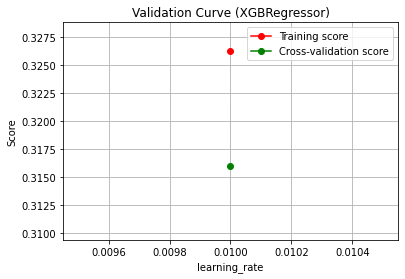

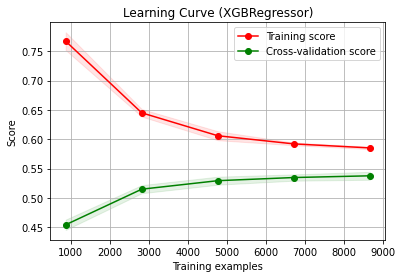

------------------------------------------------------------------------------------
R^2 score on validation set (seasonal_residual):  0.5275732321730074
MSE on validation set (seasonal_residual):  0.06871873108848954


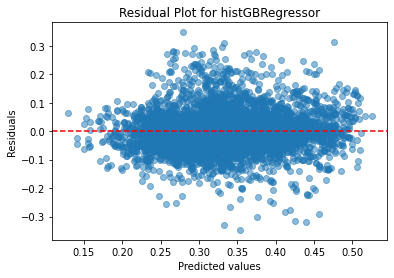

------------------------------------------------------------------------------------
KAN_L
R^2 score on test set (seasonal_residual):  0.5666527963029222
MSE on test set (seasonal_residual):  0.833946818577298


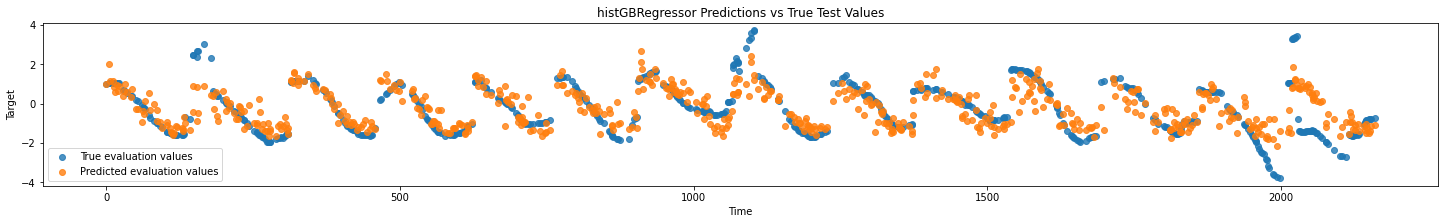

------------------------------------------------------------------------------------
KPC_L
R^2 score on test set (seasonal_residual):  0.631139784324913
MSE on test set (seasonal_residual):  0.4538214021632471


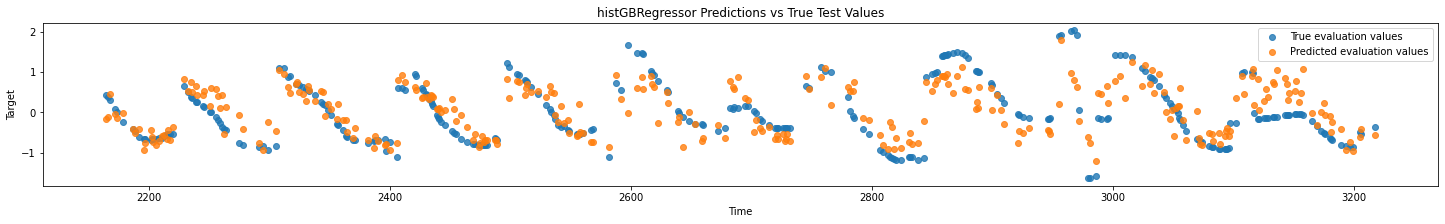

------------------------------------------------------------------------------------
MIT
R^2 score on test set (seasonal_residual):  0.5266363043772735
MSE on test set (seasonal_residual):  0.9769260126711107


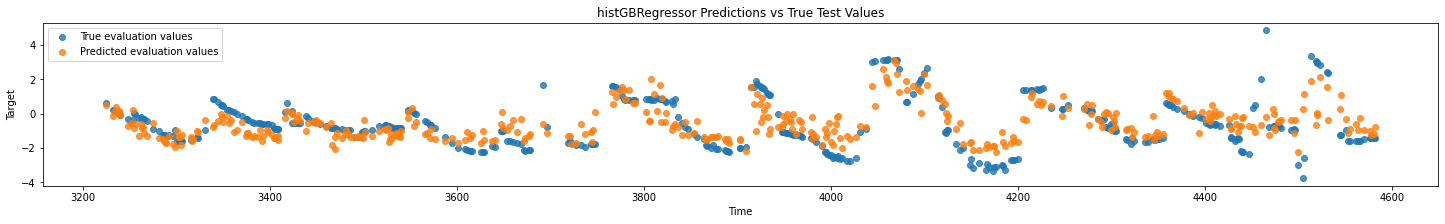

------------------------------------------------------------------------------------
NUK_L
R^2 score on test set (seasonal_residual):  0.6346712535045977
MSE on test set (seasonal_residual):  0.8283154892617909


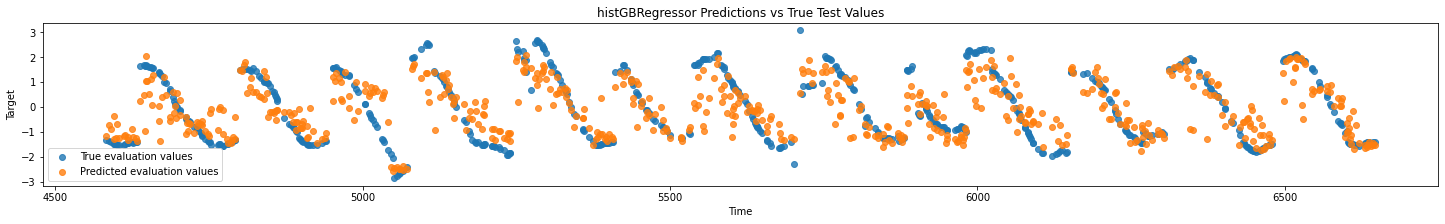

------------------------------------------------------------------------------------
NUK_U
R^2 score on test set (seasonal_residual):  0.5879157722497759
MSE on test set (seasonal_residual):  0.4315992683166271


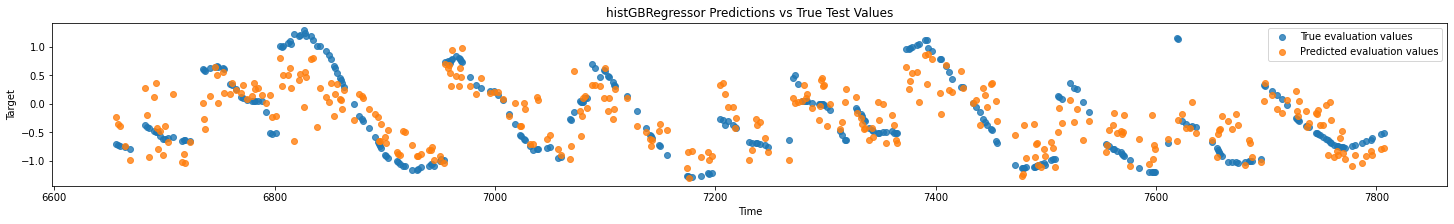

------------------------------------------------------------------------------------
QAS_L
R^2 score on test set (seasonal_residual):  0.7561794965568561
MSE on test set (seasonal_residual):  0.7764247873168741


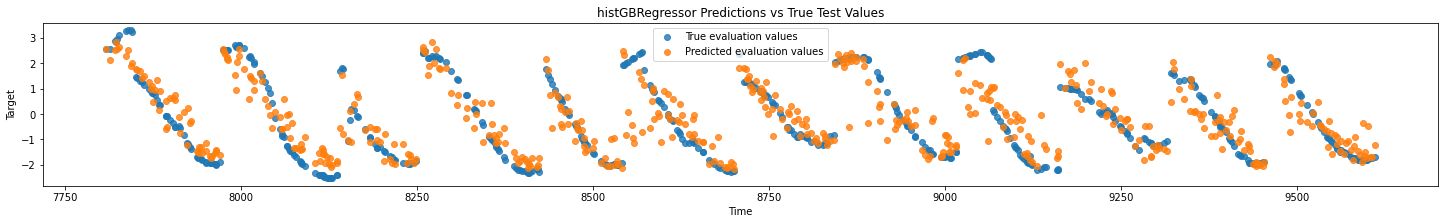

------------------------------------------------------------------------------------
QAS_U
R^2 score on test set (seasonal_residual):  0.3588607700965063
MSE on test set (seasonal_residual):  0.4620514013656412


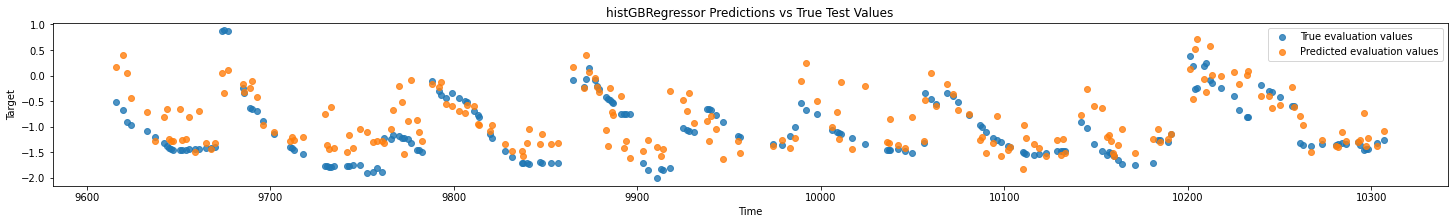

------------------------------------------------------------------------------------
SCO_L
R^2 score on test set (seasonal_residual):  0.7360190340824313
MSE on test set (seasonal_residual):  0.4678655167655437


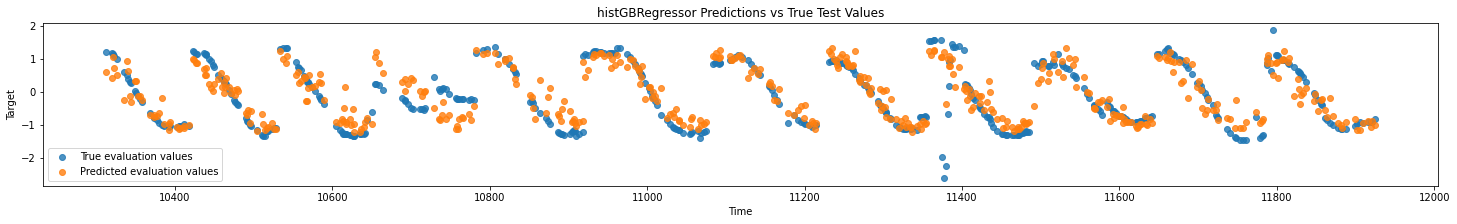

------------------------------------------------------------------------------------
SCO_U
R^2 score on test set (seasonal_residual):  0.799565072127358
MSE on test set (seasonal_residual):  0.32338151848755725


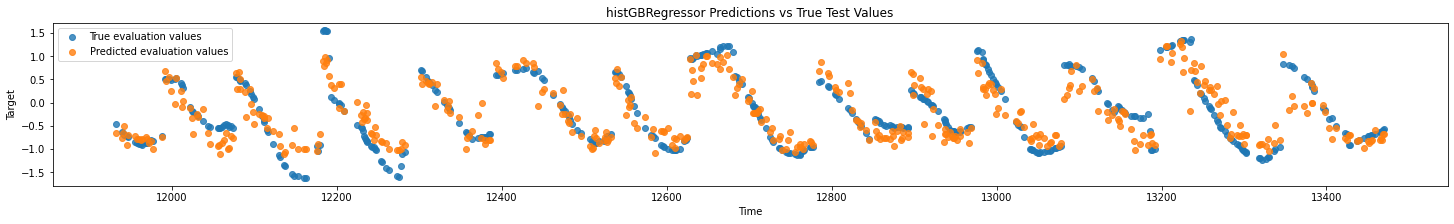

------------------------------------------------------------------------------------
TAS_L
R^2 score on test set (seasonal_residual):  0.7107429551141203
MSE on test set (seasonal_residual):  0.5701724479379097


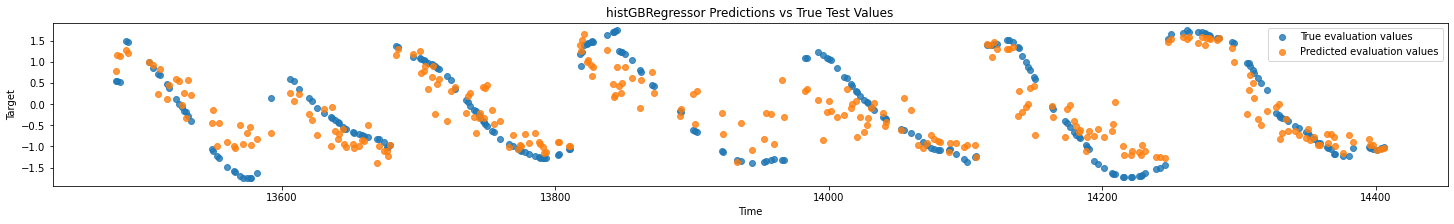

------------------------------------------------------------------------------------
THU_L
R^2 score on test set (seasonal_residual):  0.6150538650384363
MSE on test set (seasonal_residual):  0.38709338397521237


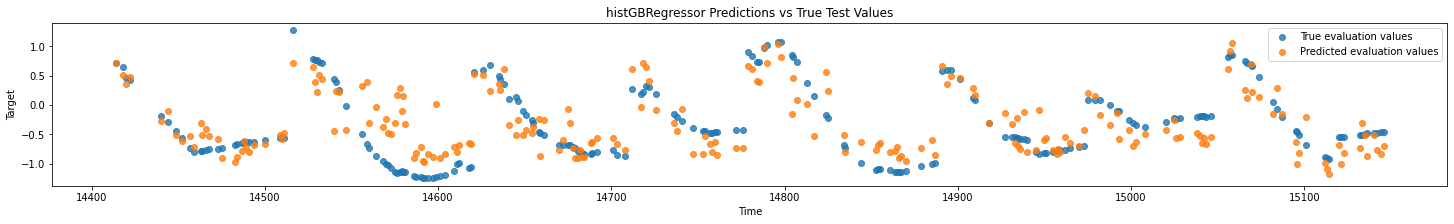

------------------------------------------------------------------------------------
UPE_L
R^2 score on test set (seasonal_residual):  0.6242235164026544
MSE on test set (seasonal_residual):  0.5096227114813596


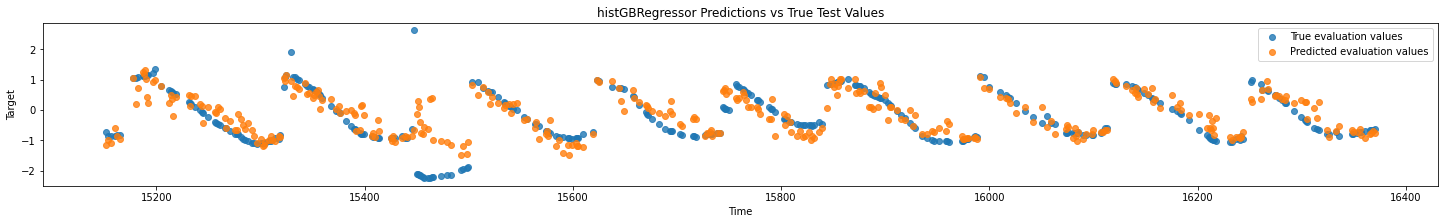

------------------------------------------------------------------------------------
UPE_U
R^2 score on test set (seasonal_residual):  0.48926734268534955
MSE on test set (seasonal_residual):  0.39360702491087357


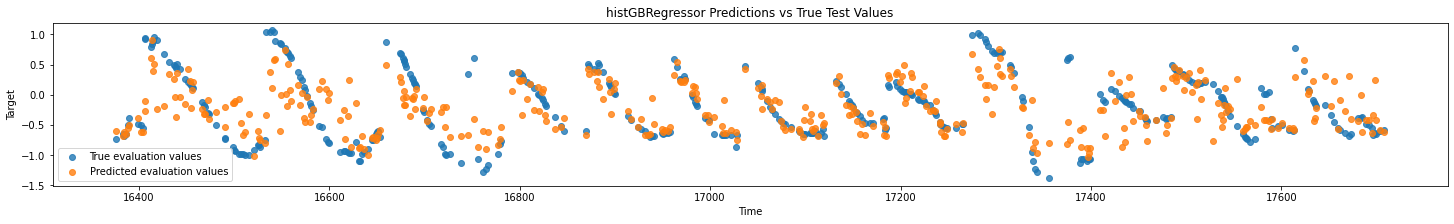

In [41]:
# This bit to find best HistGradientBoostingRegressor model for when Ablation == True and for both target variables
model = HistGradientBoostingRegressor()

# Define the hyperparameter grid for tuning
#hgb_params = {
#    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
#    'max_iter': [100, 200, 300, 400, 500],
#    'max_depth': [5, 7, 9, 11, 13, 15],
#    'min_samples_leaf': [10, 20, 30, 50, 80, 100],
#    'max_leaf_nodes': [20, 31, 50, 70, 100, 150],
#    'l2_regularization': [0, 0.1, 0.5]
#}

#Old params

param_grid = {
    'max_depth': [3],#[3, 5, 7],
    'min_samples_leaf': [1],#[1, 3, 5],
    'learning_rate': [0.1],#[0.1, 0.01, 0.001],
    'max_iter': [100],#[100, 500, 1000],
    'l2_regularization': [0.5],#[0, 0.1, 0.5]
}

# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=cv, n_jobs=-1, verbose=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)


# Print the best hyperparameters and the corresponding R^2 score on the test set
print(f"Best hyperparameters_{y}: ", grid_search.best_params_)
print('------------------------------------------------------------------------------------')
# Save the best model parameters as 'model' variable
exec(f"hist_model_{y} = grid_search.best_estimator_")

# Evaluate the best model on the test set
y_pred = eval(f"hist_model_{y}").predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=False)
print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])
mean_test_score = grid_search.cv_results_["mean_test_score"][0]
std_test_score = grid_search.cv_results_["std_test_score"][0]

best_estimator = grid_search.best_estimator_
param_name = 'learning_rate'
param_range = np.arange(0.01, 0.05, 0.1)
plot_validation_curve(best_estimator, "Validation Curve (XGBRegressor)", X_train, y_train, param_name, param_range, cv=cv)
plt.show()

plot_learning_curve(best_estimator, "Learning Curve (XGBRegressor)", X_train, y_train, cv=cv)
plt.show()

print('------------------------------------------------------------------------------------')
print(f"R^2 score on validation set ({y}): ", r2)
print(f"MSE on validation set ({y}): ", mse)

residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot for histGBRegressor")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = eval(f"xgb_model_{y}").predict(X_test_station)
    y_pred_station = scaler.inverse_transform(y_pred_station.reshape(-1, 1))
    y_test_station = scaler.inverse_transform(y_test_station.values.reshape(-1, 1))
    
    y_pred_train_station = eval(f"xgb_model_{y}").predict(X_test_station)
    r2_station = r2_score(y_test_station, y_pred_station)
    mse_station = mean_squared_error(y_test_station, y_pred_station, squared=False)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"MSE on test set ({y}): ", mse_station)
    
    plt.figure(figsize=(25, 3))
    plt.scatter(X_test_station.index, y_test_station, label="True evaluation values", alpha=0.8)
    plt.scatter(X_test_station.index, y_pred_station, label="Predicted evaluation values", alpha=0.8)
   
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.title("histGBRegressor Predictions vs True Test Values")
    plt.legend()
    plt.show()

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
------------------------------------------------------------------------------------
R^2 score on validation set (seasonal_residual):  0.5848159588894841
MSE on validation set (seasonal_residual):  0.06336973859276847
------------------------------------------------------------------------------------
R^2 score on validation set (seasonal_residual):  0.5848159588894841
MSE on validation set (seasonal_residual):  0.06336973859276847


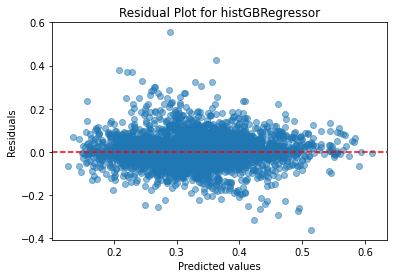

------------------------------------------------------------------------------------
KAN_L
R^2 score on test set (seasonal_residual):  0.4889168545425444
MSE on test set (seasonal_residual):  0.9101757741319825


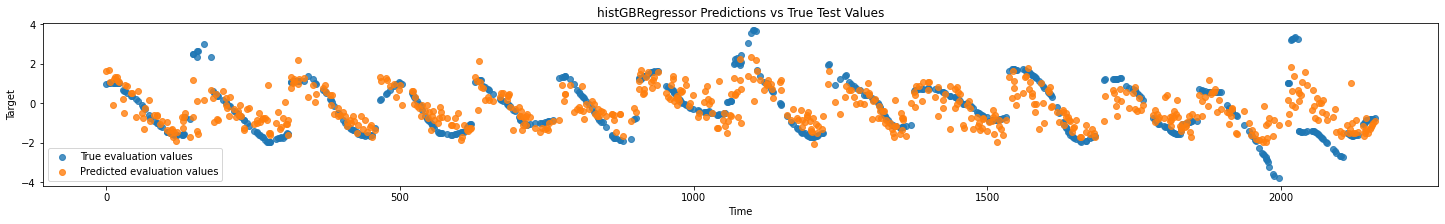

------------------------------------------------------------------------------------
KPC_L
R^2 score on test set (seasonal_residual):  0.3445926680758742
MSE on test set (seasonal_residual):  0.593381713463711


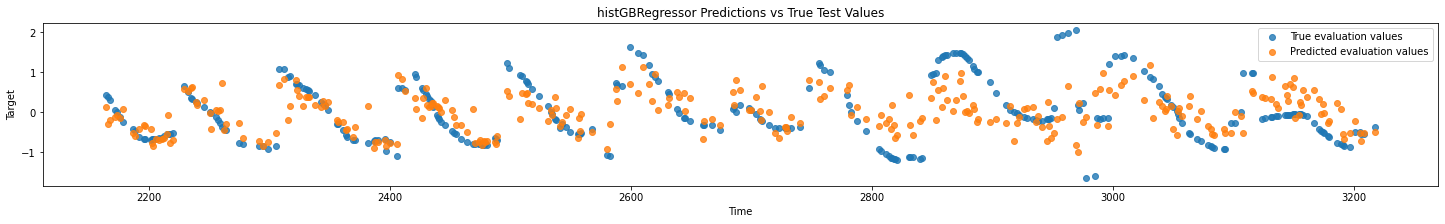

------------------------------------------------------------------------------------
MIT
R^2 score on test set (seasonal_residual):  0.37503476262085456
MSE on test set (seasonal_residual):  0.9107106760760281


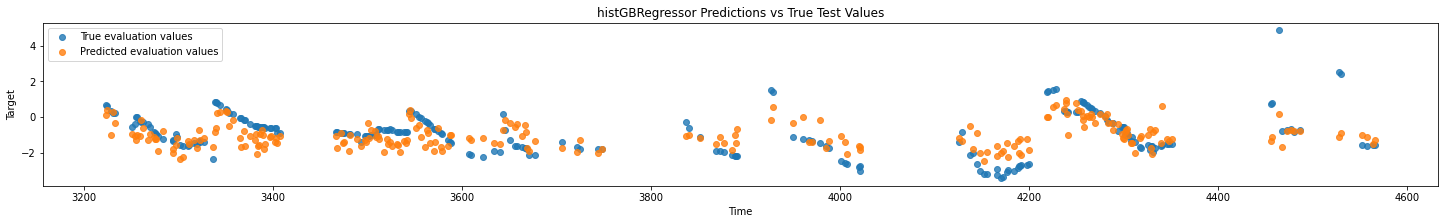

------------------------------------------------------------------------------------
NUK_L
R^2 score on test set (seasonal_residual):  0.5553700445757445
MSE on test set (seasonal_residual):  0.8820760015405158


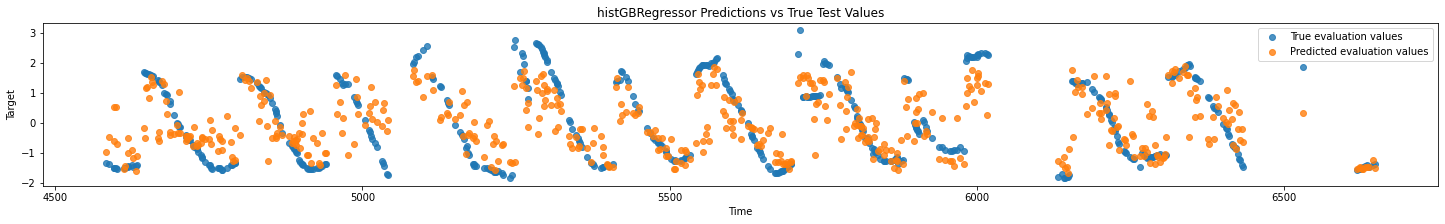

------------------------------------------------------------------------------------
NUK_U
R^2 score on test set (seasonal_residual):  0.5359891313909941
MSE on test set (seasonal_residual):  0.458979024492525


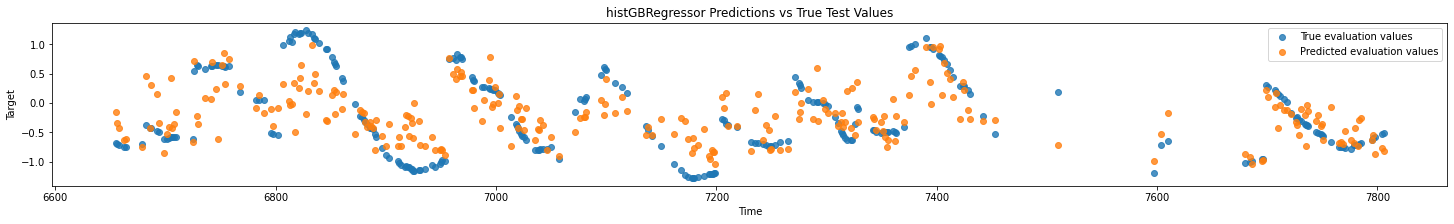

------------------------------------------------------------------------------------
QAS_L
R^2 score on test set (seasonal_residual):  0.6315663680249859
MSE on test set (seasonal_residual):  1.017158197560833


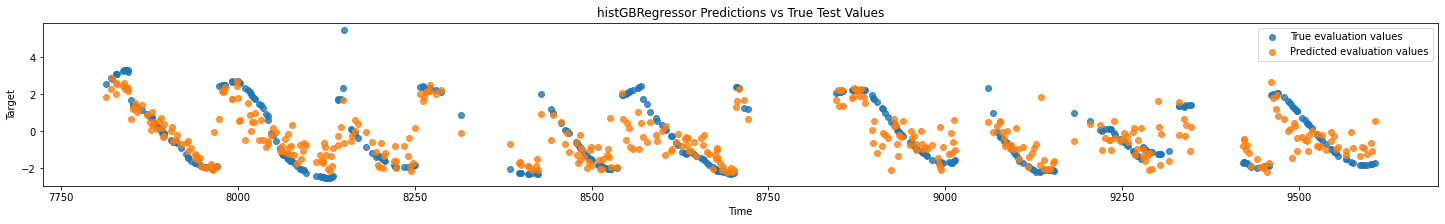

------------------------------------------------------------------------------------
QAS_U
R^2 score on test set (seasonal_residual):  0.5823449790261088
MSE on test set (seasonal_residual):  0.3593269754637604


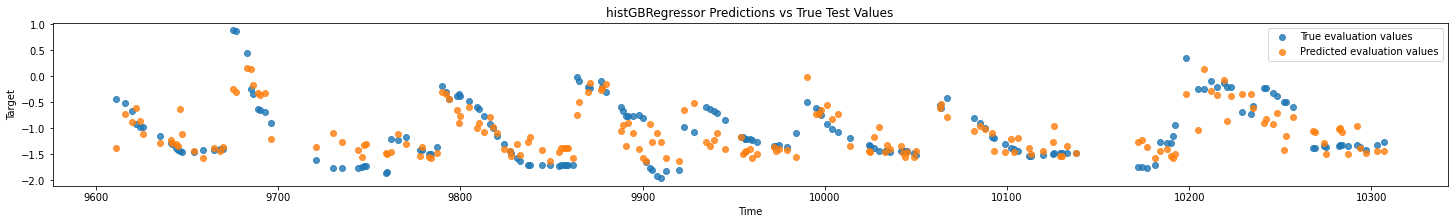

------------------------------------------------------------------------------------
SCO_L
R^2 score on test set (seasonal_residual):  0.6047774234482057
MSE on test set (seasonal_residual):  0.572473783851758


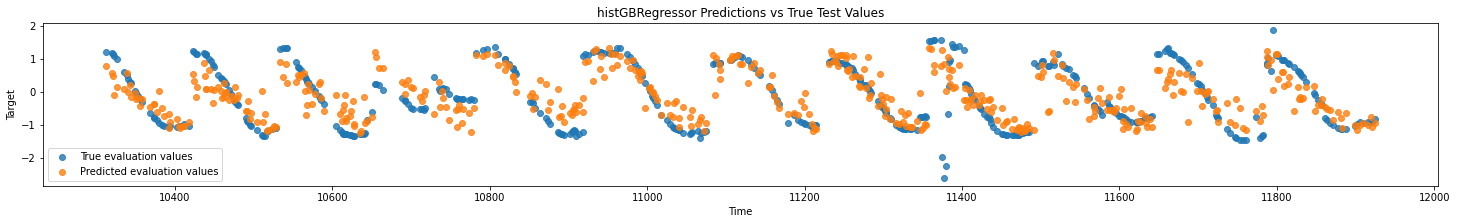

------------------------------------------------------------------------------------
SCO_U
R^2 score on test set (seasonal_residual):  0.7286101830812959
MSE on test set (seasonal_residual):  0.3818742758945492


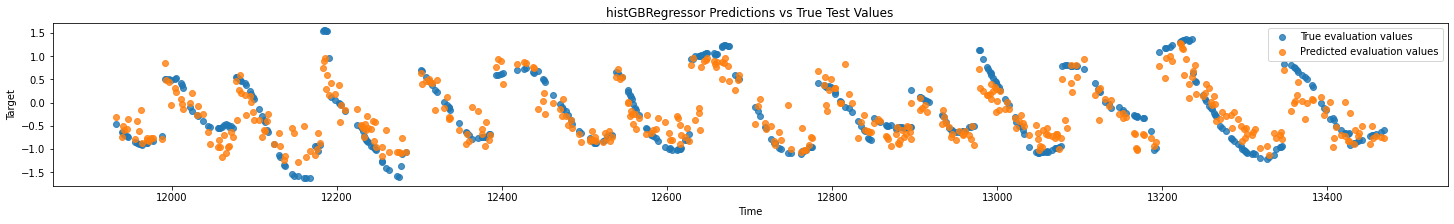

------------------------------------------------------------------------------------
TAS_L
R^2 score on test set (seasonal_residual):  0.68254682497661
MSE on test set (seasonal_residual):  0.5808355127576292


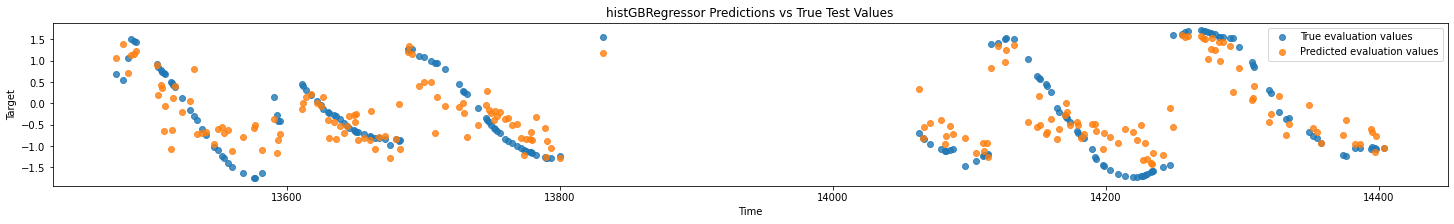

------------------------------------------------------------------------------------
THU_L
R^2 score on test set (seasonal_residual):  0.5777871365674161
MSE on test set (seasonal_residual):  0.39063359261089436


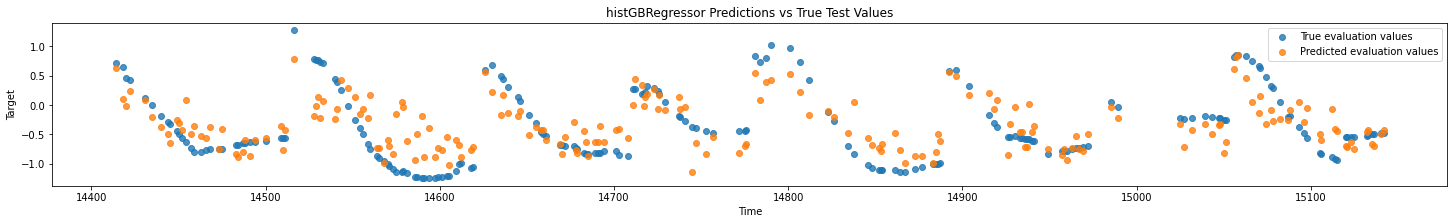

------------------------------------------------------------------------------------
UPE_L
R^2 score on test set (seasonal_residual):  0.5715113103701099
MSE on test set (seasonal_residual):  0.5315157265345256


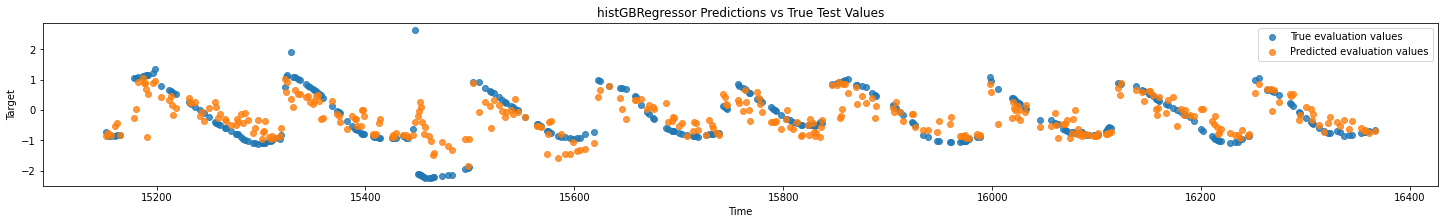

------------------------------------------------------------------------------------
UPE_U
R^2 score on test set (seasonal_residual):  0.5380599363973054
MSE on test set (seasonal_residual):  0.3595975235975423


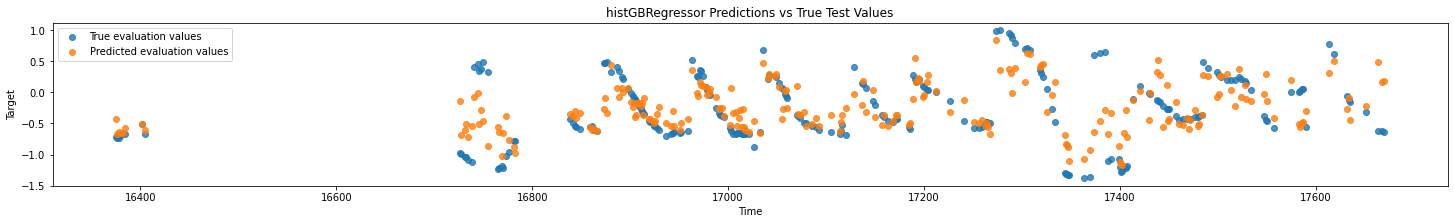

In [46]:
from sklearn.neighbors import KNeighborsRegressor


# Create the k-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor()

# Define hyperparameter search space
param_grid = {
    'n_neighbors': range(1, 11),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create grid search object
grid_search = GridSearchCV(knn_model, param_grid, cv=cv, n_jobs=-1, verbose = 2) #, scoring='neg_mean_squared_error'

# Fit the grid search object to the training data
grid_search.fit(X_train_base, y_train_base)

# Get the best estimator
best_knn_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_base = best_knn_model.predict(X_test_base)
r2 = r2_score(y_test_base, y_pred_base)
mse = mean_squared_error(y_test_base, y_pred_base, squared=False)

print("Best hyperparameters:", grid_search.best_params_)
print('------------------------------------------------------------------------------------')
print(f"R^2 score on validation set ({y}): ", r2)
print(f"MSE on validation set ({y}): ", mse)


#print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
#print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])
#mean_test_score = grid_search.cv_results_["mean_test_score"][0]
#std_test_score = grid_search.cv_results_["std_test_score"][0]

#best_estimator = grid_search.best_estimator_
#param_name = 'learning_rate'
#param_range = np.arange(0.01, 0.05, 0.1)
#plot_validation_curve(best_estimator, "Validation Curve (XGBRegressor)", X_train, y_train, param_name, param_range, cv=cv)
#plt.show()

#plot_learning_curve(best_estimator, "Learning Curve (XGBRegressor)", X_train, y_train, cv=cv)
#plt.show()

print('------------------------------------------------------------------------------------')
print(f"R^2 score on validation set ({y}): ", r2)
print(f"MSE on validation set ({y}): ", mse)

residuals = y_test_base  - y_pred_base

plt.scatter(y_pred_base, residuals, alpha=0.5)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot for histGBRegressor")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train_base.loc[X_train_base['stid'] == value]
    X_test_station = X_test_base.loc[X_test_base['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train_base.loc[X_train_station.index]
    y_test_station = y_test_base.loc[X_test_station.index]

    y_pred_station = best_knn_model.predict(X_test_station)
    y_pred_station = scaler.inverse_transform(y_pred_station.reshape(-1, 1))
    y_test_station = scaler.inverse_transform(y_test_station.values.reshape(-1, 1))
    
    y_pred_train_station = best_knn_model.predict(X_test_station)
    r2_station = r2_score(y_test_station, y_pred_station)
    mse_station = mean_squared_error(y_test_station, y_pred_station, squared=False)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"MSE on test set ({y}): ", mse_station)
    
    plt.figure(figsize=(25, 3))
    plt.scatter(X_test_station.index, y_test_station, label="True evaluation values", alpha=0.8)
    plt.scatter(X_test_station.index, y_pred_station, label="Predicted evaluation values", alpha=0.8)
   
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.title("histGBRegressor Predictions vs True Test Values")
    plt.legend()
    plt.show()


Fitting 5 folds for each of 1 candidates, totalling 5 fits


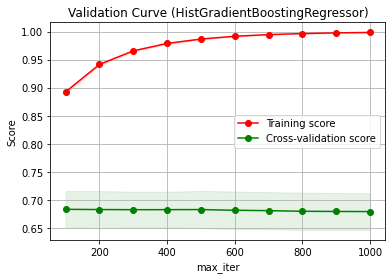

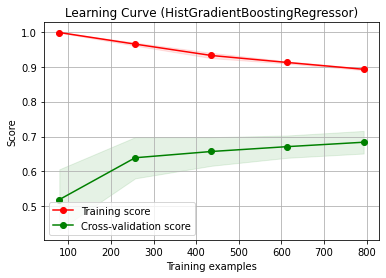

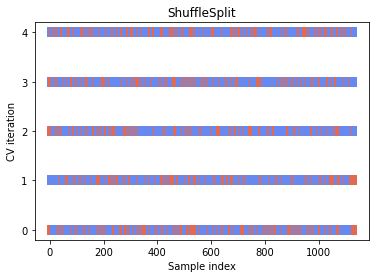

Overall R^2 score on test set (seasonal_residual):  0.7303909138481528
Overall RMSE on test set (seasonal_residual):  0.4750039932023859
SCO_L
R^2 score on test set (seasonal_residual):  0.7303909138481528
RMSE on test set (seasonal_residual):  0.4750039932023859


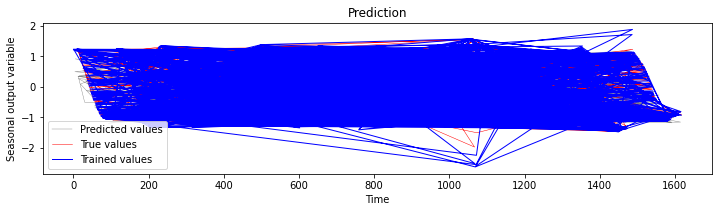

[CV 2/5] END l2_regularization=0.5, learning_rate=0.1, max_depth=3, max_iter=100, min_samples_leaf=1;, score=0.727 total time=   0.2s
[CV 1/5] END l2_regularization=0.5, learning_rate=0.1, max_depth=3, max_iter=100, min_samples_leaf=1;, score=0.638 total time=   0.2s
[CV 4/5] END l2_regularization=0.5, learning_rate=0.1, max_depth=3, max_iter=100, min_samples_leaf=1;, score=0.711 total time=   0.2s
[CV 5/5] END l2_regularization=0.5, learning_rate=0.1, max_depth=3, max_iter=100, min_samples_leaf=1;, score=0.660 total time=   0.2s
[CV 3/5] END l2_regularization=0.5, learning_rate=0.1, max_depth=3, max_iter=100, min_samples_leaf=1;, score=0.682 total time=   0.2s


In [611]:
# This bit to find best HistGradientBoostingRegressor model for when Ablation == True and for both target variables
model = HistGradientBoostingRegressor()

# Define the hyperparameter grid for tuning
#hgb_params = {
#    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
#    'max_iter': [100, 200, 300, 400, 500],
#    'max_depth': [5, 7, 9, 11, 13, 15],
#    'min_samples_leaf': [10, 20, 30, 50, 80, 100],
#    'max_leaf_nodes': [20, 31, 50, 70, 100, 150],
#    'l2_regularization': [0, 0.1, 0.5]
#}

#Old params

param_grid = {
    'max_depth': [3],#[3, 5, 7],
    'min_samples_leaf': [1],#[1, 3, 5],
    'learning_rate': [0.1],#[0.1, 0.01, 0.001],
    'max_iter': [100],#[100, 500, 1000],
    'l2_regularization': [0.5],#[0, 0.1, 0.5]
}

# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=cv, n_jobs=-1, verbose=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding R^2 score on the test set

# Save the best model parameters as 'model' variable
exec(f"hist_model_{y} = grid_search.best_estimator_")

best_estimator = grid_search.best_estimator_

param_name = 'max_iter'
param_range = np.arange(100, 1100, 100)
plot_validation_curve(best_estimator, "Validation Curve (HistGradientBoostingRegressor)", X_train, y_train, param_name, param_range, cv=cv)
plt.show()

plot_learning_curve(best_estimator, "Learning Curve (HistGradientBoostingRegressor)", X_train, y_train, cv=cv)
plt.show()

fig, ax = plt.subplots()
plot_cv_indices(cv, X_train, y_train, ax, cv.get_n_splits(X_train, y_train))
plt.show()

# Evaluate the best model on the test set
y_pred = eval(f"hist_model_{y}").predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Overall R^2 score on test set ({y}): ", r2)
print(f"Overall RMSE on test set ({y}): ", mse)

for value, station_name in enumerate(station_names):
    print(station_name)

    plt.figure(figsize=(10,10))
    plt.subplot(4,1,4)
    plt.title("Prediction")
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = eval(f"hist_model_{y}").predict(X_test_station)
    r2_station = r2_score(y_test_station, y_pred_station)
    mse_station = mean_squared_error(y_test_station, y_pred_station, squared=False)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"RMSE on test set ({y}): ", mse_station)

    # Plot the seasonal output variable, trained values, tested values, and predicted values
    plt.plot(y_test_station.index, y_pred_station, label= 'Predicted values', color='grey', linewidth=0.4)
    plt.plot(y_test_station.index, y_test_station, label='True values', color='red', linewidth=0.5)
    plt.plot(y_train_station.index, y_train_station, label='Trained values', color='blue', linewidth=1)
    
    # Plot the pre_max values
    #plt.scatter(indices_pre_max, df.loc[indices_pre_max, 'seasonal_residual'], c='r', marker='.', label='pre_max', s=4 )

    # Plot the post_max values
    #plt.scatter(indices_post_max, df.loc[indices_post_max, 'seasonal_residual'], c='g', marker='.', label='post_max',s=4)

    # Plot the pre_min values
    #plt.scatter(indices_pre_min, df.loc[indices_pre_min, 'seasonal_residual'], c='r', marker='.', label='pre_min',s=4)

    # Plot the post_min values
    #plt.scatter(indices_post_min, df.loc[indices_post_min, 'seasonal_residual'], c='g', marker='.', label='post_min',s=4)

    plt.xlabel('Time')
    plt.ylabel('Seasonal output variable')
    plt.legend()
    plt.show()


In [153]:
filter = expanded_indices_first

# Evaluate the best model on the test set
y_pred =  hist_model_seasonal_residual.predict(X_train.iloc[X_train.index.isin(filter)]) #eval(f"xgb_model_{y}").predict(X_test.iloc[filter])
y_test_filter = y_train.iloc[y_train.index.isin(filter)]
r2 = r2_score(y_test_filter, y_pred)
mse = mean_squared_error(y_test_filter, y_pred, squared=False)
print(f"R^2 score on test set ({y}): ", r2)
print(f"MSE on test set ({y}): ", mse)

for value, station_name in enumerate(station_names):
    print(station_name, value)

    plt.figure(figsize=(10,10))
    plt.subplot(4,1,4)
    plt.title("Prediction")
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = hist_model_seasonal_residual.predict(X_test_station.iloc[X_test_station.index.isin(filter)])#eval(f"xgb_model_{y}").predict(X_test_station.iloc[filter])
    y_test_filter_station = y_test_station.iloc[y_test_station.index.isin(filter)]
    r2_station = r2_score(y_test_filter_station, y_pred_station)
    mse_station = mean_squared_error(y_test_filter_station, y_pred_station, squared=False)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"RMSE on test set ({y}): ", mse_station)

    # Plot the seasonal output variable, trained values, tested values, and predicted values
    plt.scatter(y_train_station.index, y_train_station, label='Trained values', color='blue', linewidth=1)
    plt.scatter(y_test_filter_station.index, y_pred_station, label= 'Predicted values', color='grey', linewidth=0.4)
    plt.scatter(y_test_filter_station.index, y_test_station.iloc[y_test_station.index.isin(filter)], label='True values', color='red', linewidth=0.5)

    # Plot the pre_max values
    #plt.scatter(indices_pre_max, df.loc[indices_pre_max, 'seasonal_residual'], c='r', marker='.', label='pre_max', s=4 )

    # Plot the post_max values
    #plt.scatter(indices_post_max, df.loc[indices_post_max, 'seasonal_residual'], c='g', marker='.', label='post_max',s=4)

    # Plot the pre_min values
    #plt.scatter(indices_pre_min, df.loc[indices_pre_min, 'seasonal_residual'], c='r', marker='.', label='pre_min',s=4)

    # Plot the post_min values
    #plt.scatter(indices_post_min, df.loc[indices_post_min, 'seasonal_residual'], c='g', marker='.', label='post_min',s=4)

    plt.xlabel('Time')
    plt.ylabel('Seasonal output variable')
    plt.legend()
    plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 17)) while a minimum of 1 is required by HistGradientBoostingRegressor.

In [134]:
X_train.columns.to_list()

['stid',
 'Air pressure (upper boom)',
 'Air temperature (upper boom)',
 'Relative humidity (upper boom) - corrected',
 'Specific humidity (upper boom)',
 'Wind speed (upper boom)',
 'Downwelling shortwave radiation - corrected',
 'Upwelling shortwave radiation - corrected',
 'Downwelling longwave radiation',
 'Upwelling longwave radiation',
 'Surface temperature',
 'Latent heat flux (upper boom)',
 'Sensible heat flux (upper boom)',
 'Albedo',
 'Cloud cover',
 'Wind from direction (upper boom)_sin',
 'Wind from direction (upper boom)_cos']

## Filter by Melting Season and get feature importances 

In [187]:
import shap

explainer = eval(f"shap.Explainer(hist_model_{y})")

###### First Melt Day

In [136]:
X_set = pd.concat([X_train, X_test])
y_set = pd.concat([y_train, y_test])

index_filter_first_melt_day = indices_first_melt_day.to_list()

shap_values = explainer(X_set.loc[index_filter_first_melt_day])
mean_abs_shap_values = shap_values.abs.mean(0)

X = X_set.loc[index_filter_first_melt_day]
y = y_set[index_filter_first_melt_day]

positive_color = "#ca0020"
negative_color = "#92c5de"

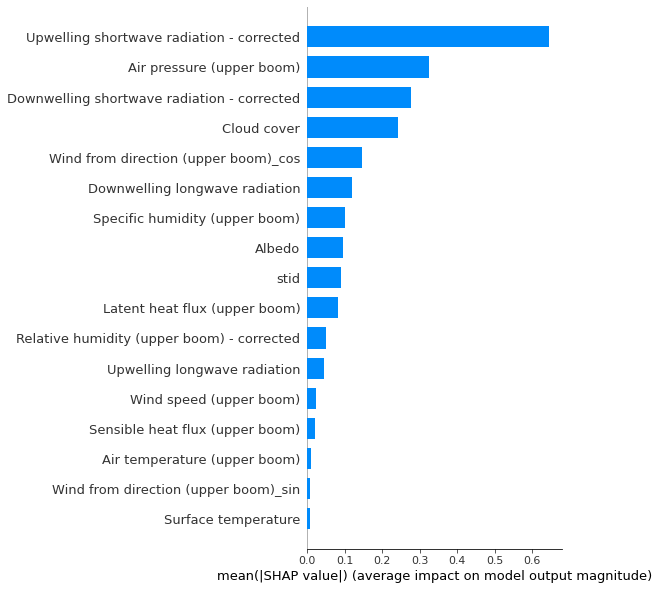

In [137]:
# Plot the SHAP summary plot using the shap.summary_plot() function for the subset of interest
shap.summary_plot(shap_values, X.loc[index_filter_first_melt_day], plot_type='bar')

Top 5 Shapley values for the beginning of melting seasons


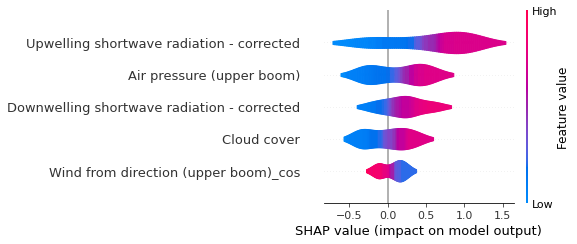

In [138]:
print("Top 5 Shapley values for the beginning of melting seasons")
shap.summary_plot(shap_values, X.loc[index_filter_first_melt_day], max_display=5,plot_type="violin")

In [139]:
# Average SHAP values for the filtered indices
avg_shap_values = np.mean(shap_values.values, axis=0)

# Create a single-row DataFrame containing the average SHAP values
avg_shap_df = pd.DataFrame([avg_shap_values], columns=X.columns)

# Generate an Explanation object using the average SHAP values
avg_explanation = shap.Explanation(
    values=avg_shap_df.values,
    base_values= explainer.expected_value,
    data=X.loc[index_filter_first_melt_day].mean(axis=0).values.reshape(1, -1),
    feature_names=X.columns,
)

shap.initjs()
shap.force_plot(avg_explanation, matplotlib=False, plot_cmap = [positive_color, negative_color])

In [157]:
shap.initjs()

positive_color = "#ca0020"
negative_color = "#92c5de"

shap.force_plot(explainer.expected_value, shap_values.values, X.loc[index_filter_first_melt_day], plot_cmap = [positive_color, negative_color])  


KeyError: '[154, 321, 476, 634, 771, 915, 1076, 1238, 1383, 1545, 1697, 1870, 2027, 2165, 2222, 2389, 2536, 2665, 2832, 2998, 3126, 3297, 3470, 3570, 3740, 3899, 4068, 4239, 4403, 4568, 4682, 4855, 4972, 5134, 5274, 5447, 5593, 5751, 5891] not in index'

In [155]:
clustering = shap.utils.hclust(X, y)
# Use mean absolute SHAP values for the bar plot
shap.plots.bar(mean_abs_shap_values, clustering=clustering)

ValueError: Found input variables with inconsistent numbers of samples: [21, 840]

AssertionError: 'shap_values' and 'features' values must have the same number of rows!

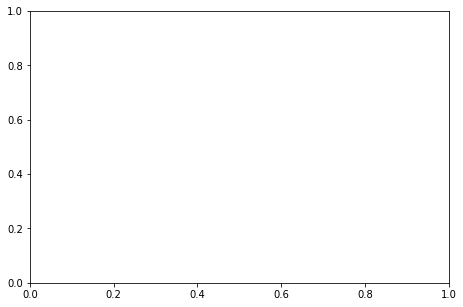

In [156]:
#shap.plots.partial_dependence("Albedo", eval(f"hist_model_{y}").predict, X, ice=False, model_expected_value=True, feature_expected_value=True)

shap_values_array = shap_values.values

shap.dependence_plot('Albedo', shap_values_array, X)



In [188]:
filter = expanded_indices_first

columns_to_remove = ["seasonal_residual"]
X_set= df[[col for col in df.columns if col not in columns_to_remove]]
y_set = df["seasonal_residual"]
#X_set = pd.concat([X_train, X_test])
#y_set = pd.concat([y_train, y_test])

X_set = X_set.loc[filter].reset_index(drop=False)
y = pd.DataFrame(y_set[filter]).reset_index(drop=True)
shap_values = explainer(X_set.iloc[:,1:])

## This bit to check credibility by R^2
y_pred = hist_model_seasonal_residual.predict(X_set.iloc[:,1:])
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred, squared=False)
print(f"R^2 score on test set: ", r2)
print(f"MSE on test set: ", mse)

## This bit to calculate the average X entries for -10/+10 days across all stations and years
#Filter by indices
#X = X_set.loc[filter].reset_index()
X =  X_set
# Merge date to group by year 
X_tempp = pd.merge(X, data[['Datetime', 'Ablation']], left_on='index', right_index=True)
X = pd.merge(X, data[['Datetime', 'Ablation']], left_on='index', right_index=True)
columns_to_remove = ['index']
X = X[[col for col in X.columns if col not in columns_to_remove]]
X['Year'] = X['Datetime'].dt.year
# Add predictions to be used in base values calculations
predictions = hist_model_seasonal_residual.predict(X.iloc[:,:17])
X['predicted'] = predictions
X_temp = X
# Create a new column 'EntryNumber' to store the entry number for each year
X['EntryNumber'] = X.groupby(['stid', 'Year']).cumcount() + 1
# Now, group the data by 'EntryNumber' and calculate the mean of each group
X = X.groupby('EntryNumber').mean().reset_index()
columns_to_remove = ['EntryNumber', 'Ablation', 'Year', 'predicted','stid_y']
X = X[[col for col in X.columns if col not in columns_to_remove]]

## This bit to calculate the average SHap values for -10/+10 days across all stations and years
avg_shap_df = pd.merge(pd.DataFrame(shap_values.values, columns= X.columns), X_tempp[['Datetime', "stid"]], left_index=True, right_index=True)
avg_shap_df['Datetime'] = pd.to_datetime(avg_shap_df['Datetime'])
# Extract the year from the DateTime column and create a new column 'Year'
avg_shap_df['Year'] = avg_shap_df['Datetime'].dt.year
# Create a new column 'EntryNumber' to store the entry number for each year
avg_shap_df['EntryNumber'] = avg_shap_df.groupby(['stid_y', 'Year']).cumcount() + 1
# Now, group the data by 'EntryNumber' and calculate the mean of each group
avg_shap_df = avg_shap_df.groupby('EntryNumber').mean().reset_index()
# Drop unnecessary columns from the result
avg_shap_df = avg_shap_df[[col for col in avg_shap_df.columns if col not in columns_to_remove]]
avg_shap_df = avg_shap_df.reset_index(drop=True)

## This bit to calculate the base value (prediction of first row - sum of shap values for this day)
base = predictions[0] - np.sum(pd.DataFrame(avg_shap_df.values).iloc[0:1,:17], axis=1) 




# Generate an Explanation object using the average SHAP values
avg_explanation = shap.Explanation(
    values = avg_shap_df.values,
    base_values =  base[0], #base,#np.mean(xgb_model_seasonal_residual.predict(X_set.loc[filter])), #explainer.expected_value,
    data = X, #X.loc[filter].mean(axis=0).values.reshape(1, -1),
    feature_names = X.columns
)

shap.initjs()

positive_color = "#ca0020"
negative_color = "#92c5de"

key = [-x for x in range(start_day_first, 0, -1)] + list(range(end_day_first + 1))

force_plot = shap.force_plot(avg_explanation, X, plot_cmap = [positive_color, negative_color], ordering_keys=key)
shap.save_html(r'../figures/SW/Results/SW_first_10.html', force_plot)

force_plot

R^2 score on test set:  0.5737664216627174
MSE on test set:  0.7794388866328167


[CV 5/8] END l2_regularization=0.5, learning_rate=0.1, max_depth=3, max_iter=100, min_samples_leaf=1;, score=0.439 total time=   0.2s
[CV 2/8] END l2_regularization=0.5, learning_rate=0.1, max_depth=3, max_iter=100, min_samples_leaf=1;, score=0.654 total time=   0.4s
[CV 8/8] END l2_regularization=0.5, learning_rate=0.1, max_depth=3, max_iter=100, min_samples_leaf=1;, score=0.394 total time=   0.2s
[CV 1/8] END l2_regularization=0.5, learning_rate=0.1, max_depth=3, max_iter=100, min_samples_leaf=1;, score=0.675 total time=   0.4s
[CV 3/8] END l2_regularization=0.5, learning_rate=0.1, max_depth=3, max_iter=100, min_samples_leaf=1;, score=0.335 total time=   0.2s
[CV 3/8] END l2_regularization=0.5, learning_rate=0.1, max_depth=3, max_iter=100, min_samples_leaf=1;, score=0.646 total time=   0.4s
[CV 2/8] END l2_regularization=0.5, learning_rate=0.1, max_depth=3, max_iter=100, min_samples_leaf=1;, score=0.428 total time=   0.2s
[CV 4/8] END l2_regularization=0.5, learning_rate=0.1, max_dep

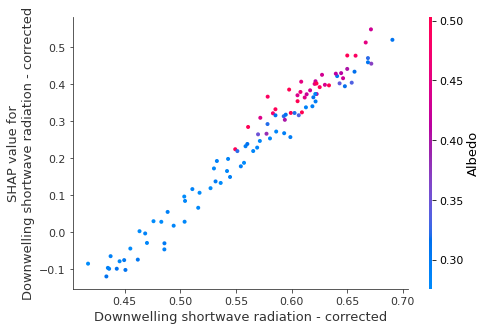

In [195]:
shap_values_array = avg_shap_df.values

shap.dependence_plot('Downwelling shortwave radiation - corrected', shap_values_array, X)


In [191]:
X.columns

Index(['stid', 'Air pressure (upper boom)', 'Air temperature (upper boom)',
       'Relative humidity (upper boom) - corrected',
       'Specific humidity (upper boom)', 'Wind speed (upper boom)',
       'Downwelling shortwave radiation - corrected',
       'Upwelling shortwave radiation - corrected',
       'Downwelling longwave radiation', 'Upwelling longwave radiation',
       'Surface temperature', 'Latent heat flux (upper boom)',
       'Sensible heat flux (upper boom)', 'Albedo', 'Cloud cover',
       'Wind from direction (upper boom)_sin',
       'Wind from direction (upper boom)_cos'],
      dtype='object')

###### Last Melt Day

In [147]:
X_set = pd.concat([X_train, X_test])
y_set = pd.concat([y_train, y_test])

index_filter_last_melt_day = indices_last_melt_day.to_list()

shap_values = explainer(X_set.loc[index_filter_last_melt_day])
mean_abs_shap_values = shap_values.abs.mean(0)
X = X_set.loc[index_filter_last_melt_day]
y = y_set[index_filter_last_melt_day]

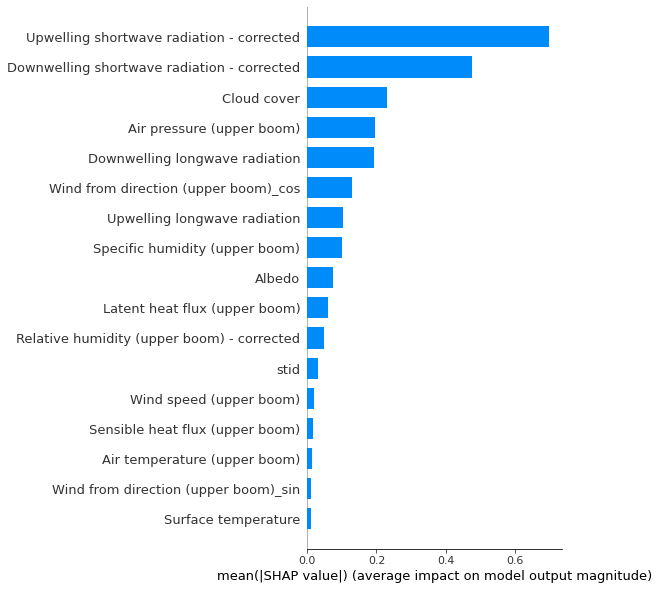

In [148]:
# Plot the SHAP summary plot using the shap.summary_plot() function for the subset of interest
shap.summary_plot(shap_values, X.loc[index_filter_last_melt_day], plot_type='bar')

Top 5 Shapley values for the beginning of melting seasons


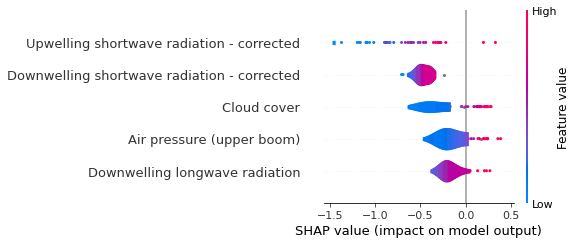

In [149]:
print("Top 5 Shapley values for the beginning of melting seasons")
shap.summary_plot(shap_values, X.loc[index_filter_last_melt_day], max_display=5 , plot_type="violin")

In [150]:
# Average SHAP values for the filtered indices
avg_shap_values = np.mean(shap_values.values, axis=0)

# Create a single-row DataFrame containing the average SHAP values
avg_shap_df = pd.DataFrame([avg_shap_values], columns=X.columns)

# Generate an Explanation object using the average SHAP values
avg_explanation = shap.Explanation(
    values=avg_shap_df.values,
    base_values=explainer.expected_value,
    data=X.loc[index_filter_last_melt_day].mean(axis=0).values.reshape(1, -1),
    feature_names=X.columns,
)

positive_color = "#ca0020"
negative_color = "#92c5de"

shap.initjs()
shap.force_plot(avg_explanation, matplotlib=False, plot_cmap = [positive_color, negative_color])

In [151]:
shap.initjs()
positive_color = "#ca0020"
negative_color = "#92c5de"
shap.force_plot(explainer.expected_value, shap_values.values, X.loc[index_filter_last_melt_day], plot_cmap = [positive_color, negative_color])



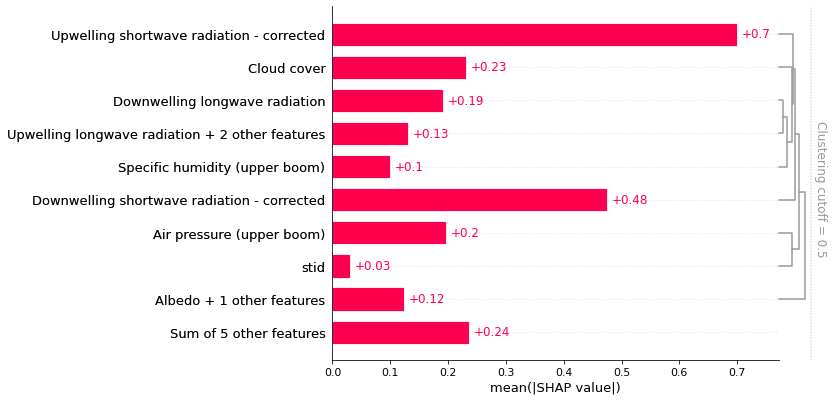

In [152]:
clustering = shap.utils.hclust(X, y)
# Use mean absolute SHAP values for the bar plot
shap.plots.bar(mean_abs_shap_values, clustering=clustering)

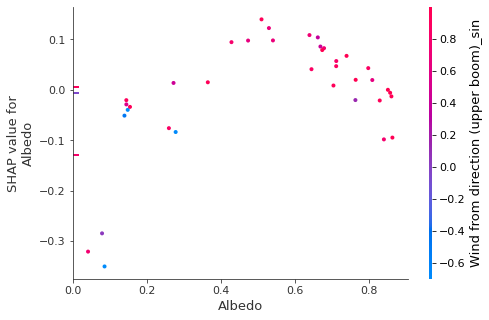

In [153]:
#shap.plots.partial_dependence("Albedo", eval(f"hist_model_{y}").predict, X, ice=False, model_expected_value=True, feature_expected_value=True)

shap_values_array = shap_values.values

shap.dependence_plot('Albedo', shap_values_array, X)



In [154]:
filter = expanded_indices_last

columns_to_remove = ["seasonal_residual"]
X_set= df[[col for col in df.columns if col not in columns_to_remove]]
y_set = df["seasonal_residual"]

y = y_set[filter]
shap_values = explainer(X_set)

## This bit to check credibility by R^2
y_pred = hist_model_seasonal_residual.predict(X_set.loc[filter])
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred, squared=False)
print(f"R^2 score on test set: ", r2)
print(f"MSE on test set: ", mse)

## This bit to calculate the average X entries for -10/+10 days across all stations and years
#Filter by indices
X = X_set.loc[filter]
# Merge date to group by year 
X = pd.merge(X, data[['Datetime', 'Ablation']], left_index=True, right_index=True)
X['Year'] = X['Datetime'].dt.year
# Add predictions to be used in base values calculations
predictions = hist_model_seasonal_residual.predict(X.iloc[:,:17])
X['predicted'] = predictions
X_temp = X
# Create a new column 'EntryNumber' to store the entry number for each year
X['EntryNumber'] = X.groupby(['stid', 'Year']).cumcount() + 1
# Now, group the data by 'EntryNumber' and calculate the mean of each group
X = X.groupby('EntryNumber').mean().reset_index()
columns_to_remove = ['EntryNumber', 'Ablation', 'Year', 'predicted','stid_y']
X = X[[col for col in X.columns if col not in columns_to_remove]]

## This bit to calculate the average SHap values for -10/+10 days across all stations and years
avg_shap_df = pd.merge(pd.DataFrame(shap_values.values, columns= X.columns).loc[filter], data[['Datetime', "stid"]], left_index=True, right_index=True)
avg_shap_df['Datetime'] = pd.to_datetime(avg_shap_df['Datetime'])
# Extract the year from the DateTime column and create a new column 'Year'
avg_shap_df['Year'] = avg_shap_df['Datetime'].dt.year
# Create a new column 'EntryNumber' to store the entry number for each year
avg_shap_df['EntryNumber'] = avg_shap_df.groupby(['stid_y', 'Year']).cumcount() + 1
# Now, group the data by 'EntryNumber' and calculate the mean of each group
avg_shap_df = avg_shap_df.groupby('EntryNumber').mean().reset_index()
# Drop unnecessary columns from the result
avg_shap_df = avg_shap_df[[col for col in avg_shap_df.columns if col not in columns_to_remove]]
avg_shap_df = avg_shap_df.reset_index(drop=True)

## This bit to calculate the base value (prediction of first row - sum of shap values for this day)
base = predictions[0] - np.sum(pd.DataFrame(avg_shap_df.values).iloc[0:1,:17], axis=1) 




# Generate an Explanation object using the average SHAP values
avg_explanation = shap.Explanation(
    values = avg_shap_df.values,
    base_values =  base[0], #base,#np.mean(xgb_model_seasonal_residual.predict(X_set.loc[filter])), #explainer.expected_value,
    data = X, #X.loc[filter].mean(axis=0).values.reshape(1, -1),
    feature_names = X.columns
)

shap.initjs()

positive_color = "#ca0020"
negative_color = "#92c5de"

key = [-x for x in range(start_day_last, 0, -1)] + list(range(end_day_last + 1))

force_plot = shap.force_plot(avg_explanation, X, plot_cmap = [positive_color, negative_color], ordering_keys=key)

shap.save_html(r'../figures/SW/Results/SW_last_10.html', force_plot)

force_plot

R^2 score on test set:  -0.2845763023763852
MSE on test set:  0.6060324531222606


-------